# Twitch PTBR Graph Analysis: Pipelines, Rationale, and Results

This notebook is organized for presentation. It documents each task end-to-end:
1. **Dataset and graph overview** (what data we have and what the graph looks like)
2. **Task A: Node attribute prediction** (`is_mature`, `twitch_partner`) using graph embeddings
3. **Task B: Link prediction** with GraphSAGE

Each task includes:
- a clear pipeline,
- justification for design choices,
- visual outputs,
- and interpretation guidance.

## Quick Dataset Outline

The Twitch PTBR dataset represents a **social network of Twitch streamers**.

- **Nodes**: streamers (one node per user)
- **Edges**: observed user-user relationships (undirected)
- **Node metadata**:
  - `days`: account age in days
  - `views`: total views
  - `mature` -> converted to `is_mature` (0/1)
  - `partner` -> converted to `twitch_partner` (0/1)

### Prediction tasks in this notebook
- **Task A (Node classification)**: predict `is_mature` and `twitch_partner` from structural embeddings.
- **Task B (Link prediction)**: predict whether a pair of users should be connected.

In [1]:
import os
import copy
import random
import warnings

import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import scipy.sparse as sp

from sklearn.base import clone
from sklearn.manifold import SpectralEmbedding, TSNE
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve,
)
from sklearn.preprocessing import StandardScaler

try:
    from xgboost import XGBClassifier
    HAVE_XGBOOST = True
except Exception:
    HAVE_XGBOOST = False

try:
    from lightgbm import LGBMClassifier
    HAVE_LIGHTGBM = True
except Exception:
    HAVE_LIGHTGBM = False

try:
    from node2vec import Node2Vec as N2V_Algo
    HAVE_NODE2VEC = True
except Exception:
    HAVE_NODE2VEC = False

warnings.filterwarnings('ignore')

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

sns.set_theme(style='whitegrid', context='talk')
plt.rcParams['figure.figsize'] = (10, 6)

print(f'Node2Vec available: {HAVE_NODE2VEC}')
print(f'XGBoost available: {HAVE_XGBOOST}')
print(f'LightGBM available: {HAVE_LIGHTGBM}')


Node2Vec available: True
XGBoost available: True
LightGBM available: True


c:\Users\stef4\Desktop\Massive Graph\community_detection\.graph_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def _to_binary(series):
    return (
        series.astype(str)
        .str.strip()
        .str.lower()
        .map({'true': 1, 'false': 0, '1': 1, '0': 0})
        .astype('Int64')
    )


def find_twitch_data_dir():
    candidates = [
        os.path.join('graph_ml', 'data', 'twitch'),
        os.path.join('data', 'twitch'),
        os.path.join('..', 'data', 'twitch'),
    ]
    for base in candidates:
        edges_path = os.path.join(base, 'musae_PTBR_edges.csv')
        target_path = os.path.join(base, 'musae_PTBR_target.csv')
        if os.path.exists(edges_path) and os.path.exists(target_path):
            return base
    raise FileNotFoundError('Could not find musae_PTBR_edges.csv and musae_PTBR_target.csv')


def load_twitch_graph(base_dir):
    edges_df = pd.read_csv(os.path.join(base_dir, 'musae_PTBR_edges.csv'))
    target_df = pd.read_csv(os.path.join(base_dir, 'musae_PTBR_target.csv'))

    target_df = target_df.rename(columns={'partner': 'twitch_partner'})
    target_df['is_mature'] = _to_binary(target_df['mature'])
    target_df['twitch_partner'] = _to_binary(target_df['twitch_partner'])

    G = nx.from_pandas_edgelist(edges_df, source='from', target='to', create_using=nx.Graph())

    attr_cols = ['days', 'views', 'is_mature', 'twitch_partner']
    attr_map = target_df.set_index('new_id')[attr_cols].to_dict(orient='index')
    nx.set_node_attributes(G, attr_map)

    valid_nodes = set(target_df['new_id'].astype(int).tolist())
    missing_attr_nodes = [n for n in G.nodes() if n not in valid_nodes]
    if missing_attr_nodes:
        G.remove_nodes_from(missing_attr_nodes)

    target_df = target_df[target_df['new_id'].isin(G.nodes())].copy()

    return G, edges_df, target_df


DATA_DIR = find_twitch_data_dir()
G, edges_df, node_df = load_twitch_graph(DATA_DIR)

degree_map = dict(G.degree())
node_df['degree'] = node_df['new_id'].map(degree_map).fillna(0).astype(int)
node_df['log_views'] = np.log10(node_df['views'].clip(lower=1))

print(f'Data directory: {DATA_DIR}')
print(f'Nodes: {G.number_of_nodes():,} | Edges: {G.number_of_edges():,}')
print(f'Density: {nx.density(G):.6f}')
print(f'Connected components: {nx.number_connected_components(G):,}')

Data directory: data\twitch
Nodes: 1,912 | Edges: 31,299
Density: 0.017132
Connected components: 1


### Whole Network Visualization

A quick “hairball” view of the entire graph structure (no attribute-based coloring).

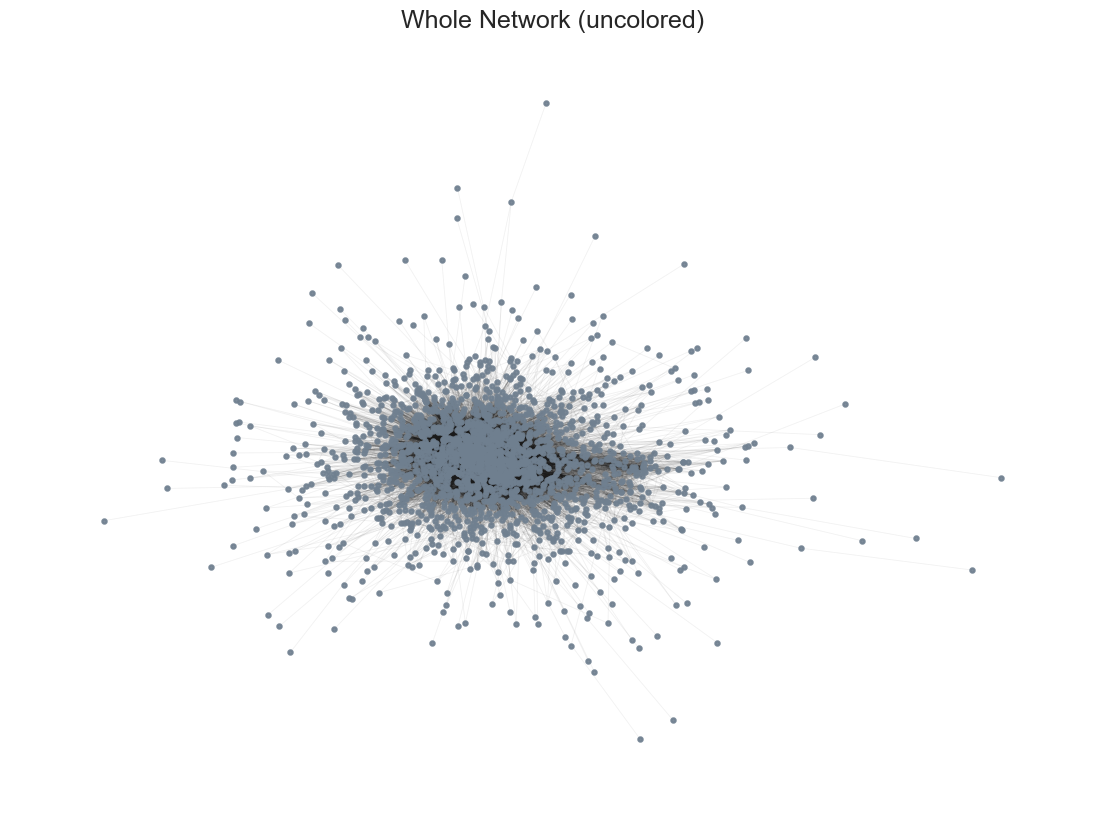

In [3]:
# Whole-network visualization (uncolored)
# If this is slow, reduce `iterations` or switch to `nx.random_layout`.
pos_full = nx.spring_layout(G, seed=SEED, k=0.25, iterations=60)

plt.figure(figsize=(14, 10))
nx.draw_networkx_edges(G, pos_full, alpha=0.06, width=0.6)
nx.draw_networkx_nodes(G, pos_full, node_size=10, node_color='slategray', alpha=0.9)
plt.title('Whole Network (uncolored)')
plt.axis('off')
plt.show()


## Notebook Task Pipelines

### Task A: Node Attribute Prediction (`is_mature`, `twitch_partner`)
`Load graph -> Build embeddings (Spectral, Node2Vec) -> Train Logistic Regression -> Evaluate (accuracy, per-class precision/recall, confusion matrix)`

### Task B: Link Prediction (GraphSAGE)
`Split edges (train/val/test, anti-leakage) -> Build structural node features -> Train GraphSAGE + MLP scorer -> Evaluate (ROC-AUC, AP, Accuracy, curves, score analysis)`

### Why this setup is defensible
- Same split/evaluation protocol across methods keeps comparisons fair.
- Simple classifier for Task A isolates embedding quality from model complexity.
- Anti-leakage split for Task B ensures we do not message-pass over validation/test links.


In [4]:
summary = {
    'num_nodes': G.number_of_nodes(),
    'num_edges': G.number_of_edges(),
    'avg_degree': np.mean([d for _, d in G.degree()]),
    'median_degree': np.median([d for _, d in G.degree()]),
    'max_degree': np.max([d for _, d in G.degree()]),
    'density': nx.density(G),
    'components': nx.number_connected_components(G),
}

print('Graph summary:')
for k, v in summary.items():
    if isinstance(v, float):
        print(f'- {k}: {v:.4f}')
    else:
        print(f'- {k}: {v:,}')

print('\nNode table preview:')
display(node_df[['new_id', 'days', 'views', 'is_mature', 'twitch_partner', 'degree']].head())

Graph summary:
- num_nodes: 1,912
- num_edges: 31,299
- avg_degree: 32.7395
- median_degree: 17.0000
- max_degree: 767
- density: 0.0171
- components: 1

Node table preview:


,new_id,days,views,is_mature,twitch_partner,degree
0,1706,1943,929459,0,1,82
1,1273,1633,11194,0,0,8
2,313,632,2850,0,0,16
3,1570,906,3422,1,0,8
4,800,267,71,0,0,2


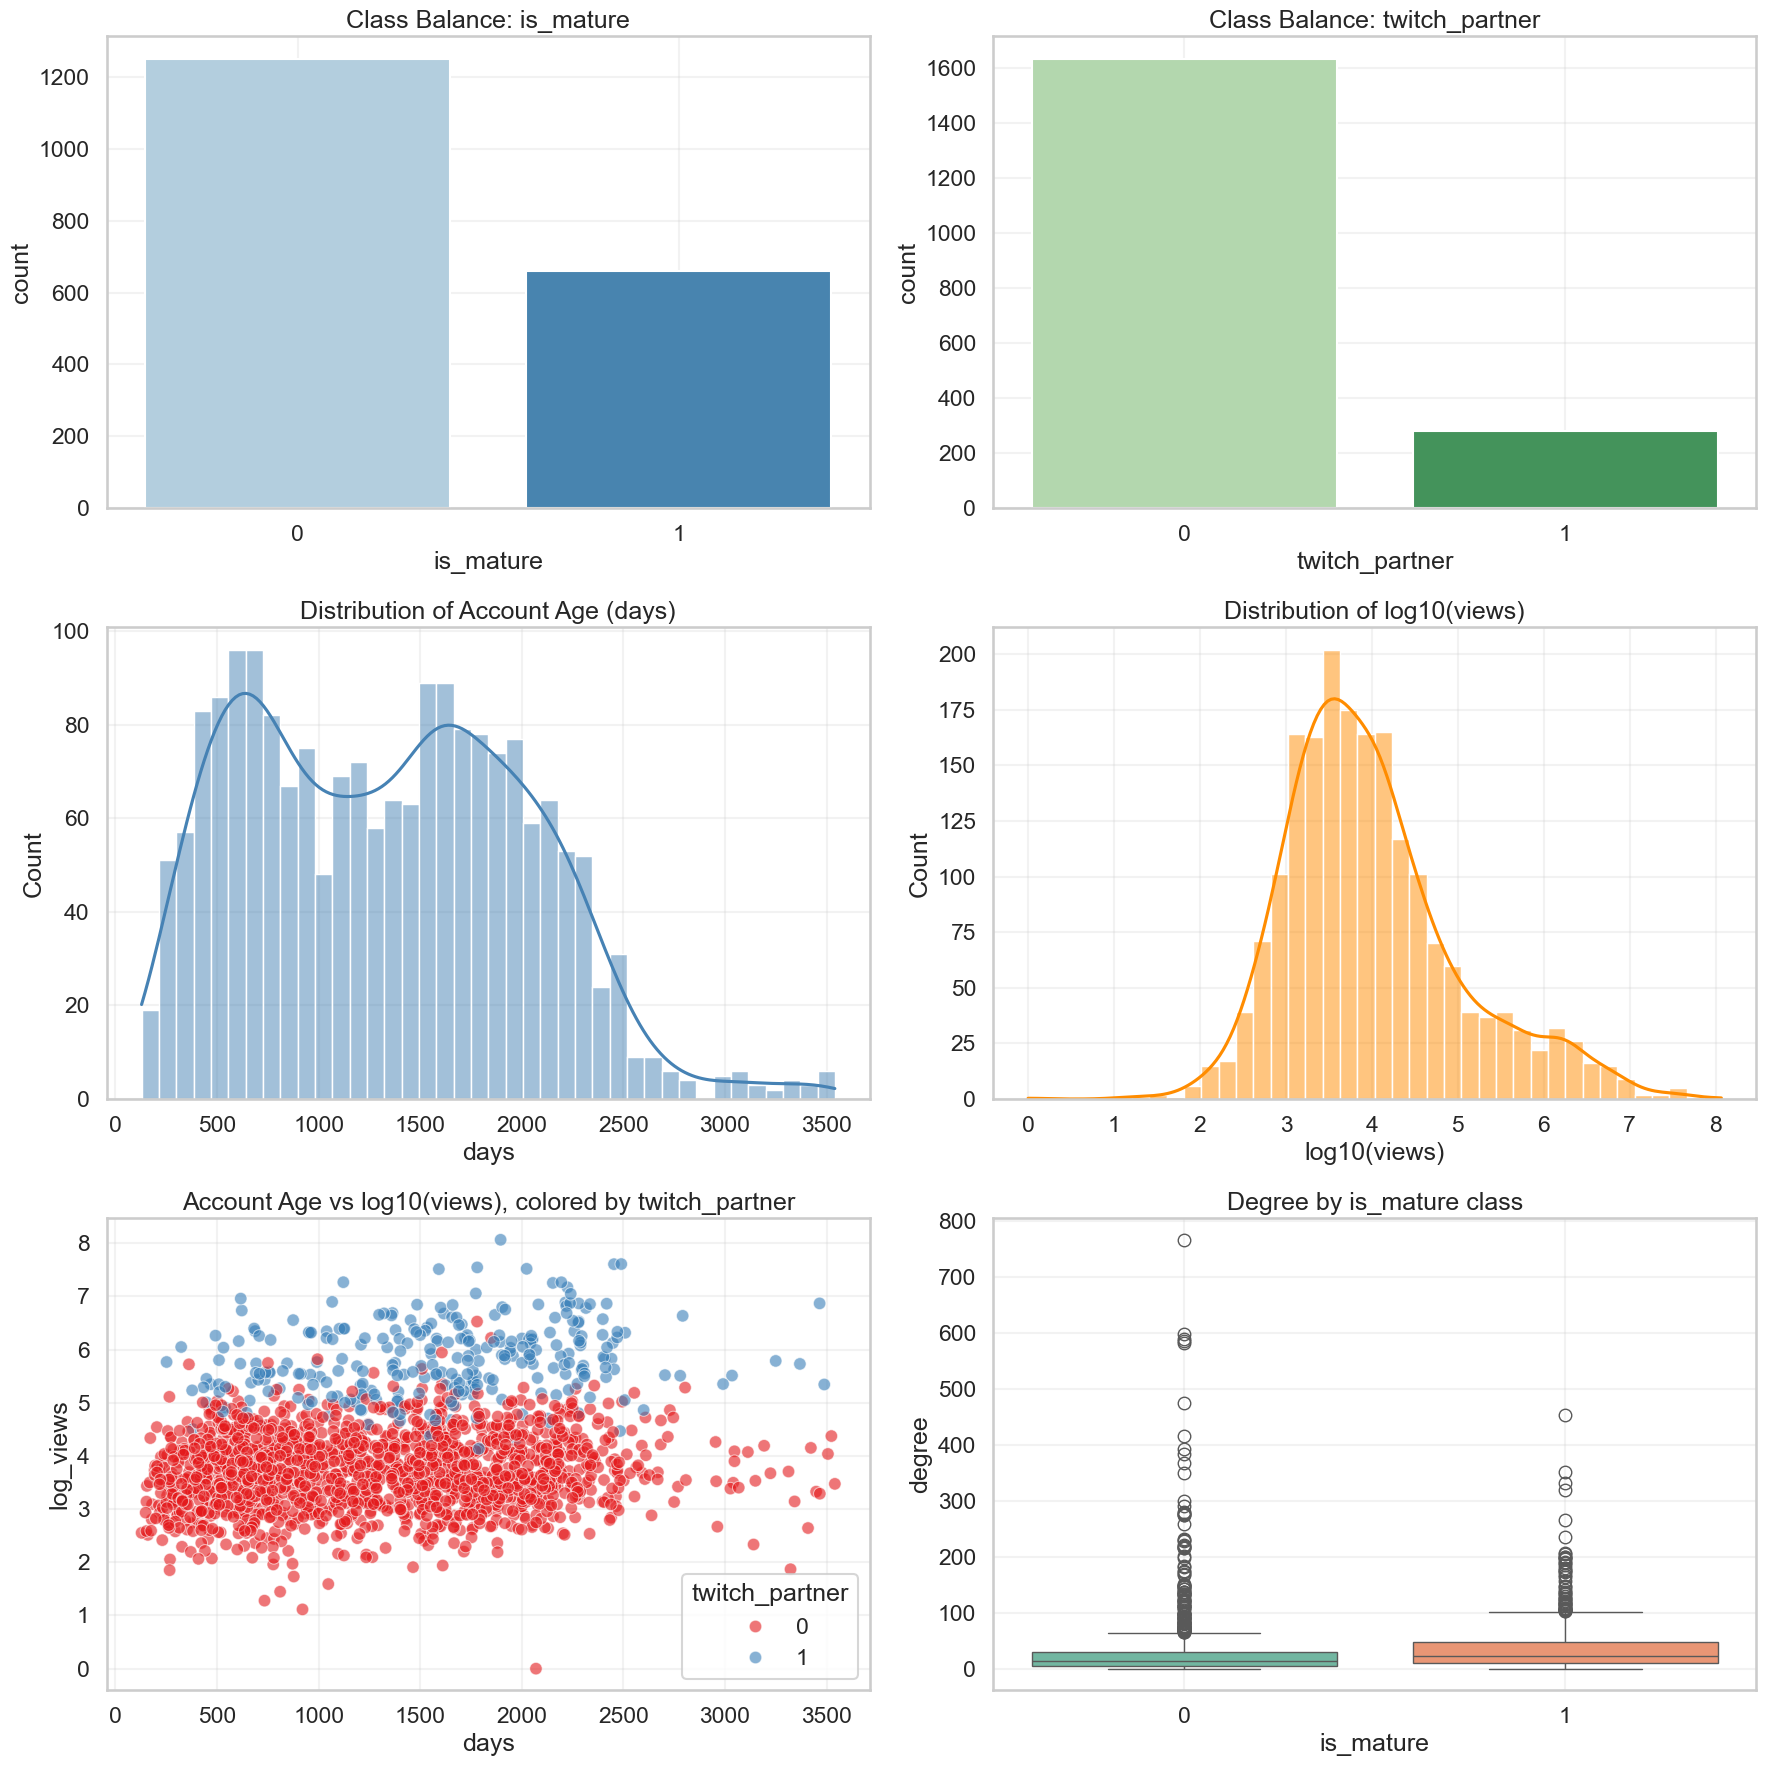

In [5]:
fig, axes = plt.subplots(3, 2, figsize=(18, 18))

sns.countplot(data=node_df, x='is_mature', palette='Blues', ax=axes[0, 0])
axes[0, 0].set_title('Class Balance: is_mature')
axes[0, 0].set_xlabel('is_mature')

sns.countplot(data=node_df, x='twitch_partner', palette='Greens', ax=axes[0, 1])
axes[0, 1].set_title('Class Balance: twitch_partner')
axes[0, 1].set_xlabel('twitch_partner')

sns.histplot(node_df['days'], bins=40, kde=True, color='steelblue', ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Account Age (days)')

sns.histplot(node_df['log_views'], bins=40, kde=True, color='darkorange', ax=axes[1, 1])
axes[1, 1].set_title('Distribution of log10(views)')
axes[1, 1].set_xlabel('log10(views)')

sns.scatterplot(
    data=node_df.sample(min(len(node_df), 2500), random_state=SEED),
    x='days',
    y='log_views',
    hue='twitch_partner',
    palette='Set1',
    alpha=0.6,
    ax=axes[2, 0],
)
axes[2, 0].set_title('Account Age vs log10(views), colored by twitch_partner')

sns.boxplot(data=node_df, x='is_mature', y='degree', palette='Set2', ax=axes[2, 1])
axes[2, 1].set_title('Degree by is_mature class')

for ax in axes.flat:
    ax.grid(alpha=0.25)

plt.tight_layout()
plt.show()

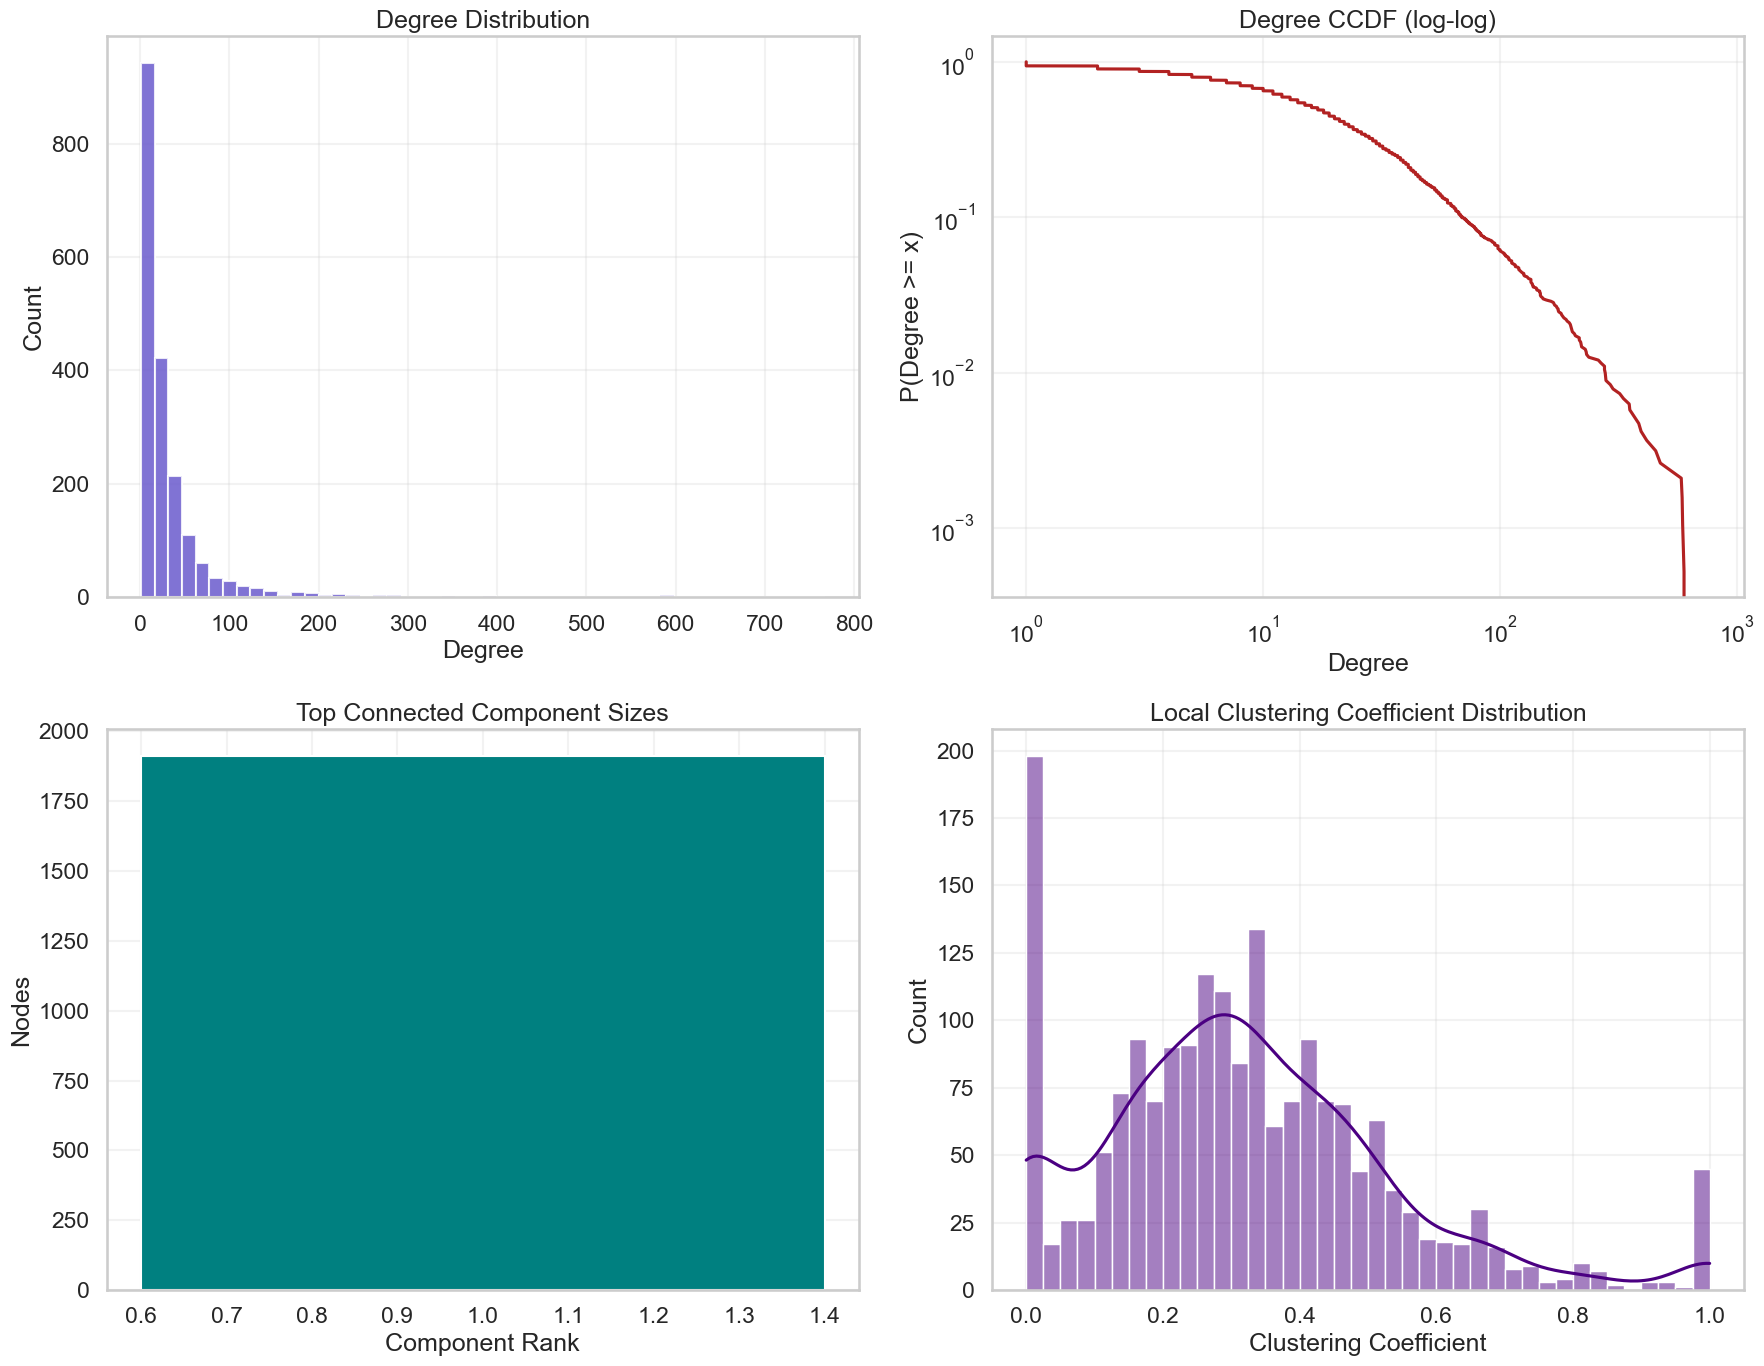

In [6]:
component_sizes = sorted([len(c) for c in nx.connected_components(G)], reverse=True)
ccdf_x = np.sort(node_df['degree'].values)
ccdf_y = 1.0 - np.arange(1, len(ccdf_x) + 1) / len(ccdf_x)

fig, axes = plt.subplots(2, 2, figsize=(18, 14))

axes[0, 0].hist(node_df['degree'], bins=50, color='slateblue', alpha=0.85)
axes[0, 0].set_title('Degree Distribution')
axes[0, 0].set_xlabel('Degree')
axes[0, 0].set_ylabel('Count')

axes[0, 1].plot(ccdf_x, ccdf_y, color='firebrick')
axes[0, 1].set_xscale('log')
axes[0, 1].set_yscale('log')
axes[0, 1].set_title('Degree CCDF (log-log)')
axes[0, 1].set_xlabel('Degree')
axes[0, 1].set_ylabel('P(Degree >= x)')

top_k = min(20, len(component_sizes))
axes[1, 0].bar(range(1, top_k + 1), component_sizes[:top_k], color='teal')
axes[1, 0].set_title('Top Connected Component Sizes')
axes[1, 0].set_xlabel('Component Rank')
axes[1, 0].set_ylabel('Nodes')

clustering_vals = np.array(list(nx.clustering(G).values()))
sns.histplot(clustering_vals, bins=40, kde=True, color='indigo', ax=axes[1, 1])
axes[1, 1].set_title('Local Clustering Coefficient Distribution')
axes[1, 1].set_xlabel('Clustering Coefficient')

for ax in axes.flat:
    ax.grid(alpha=0.25)

plt.tight_layout()
plt.show()

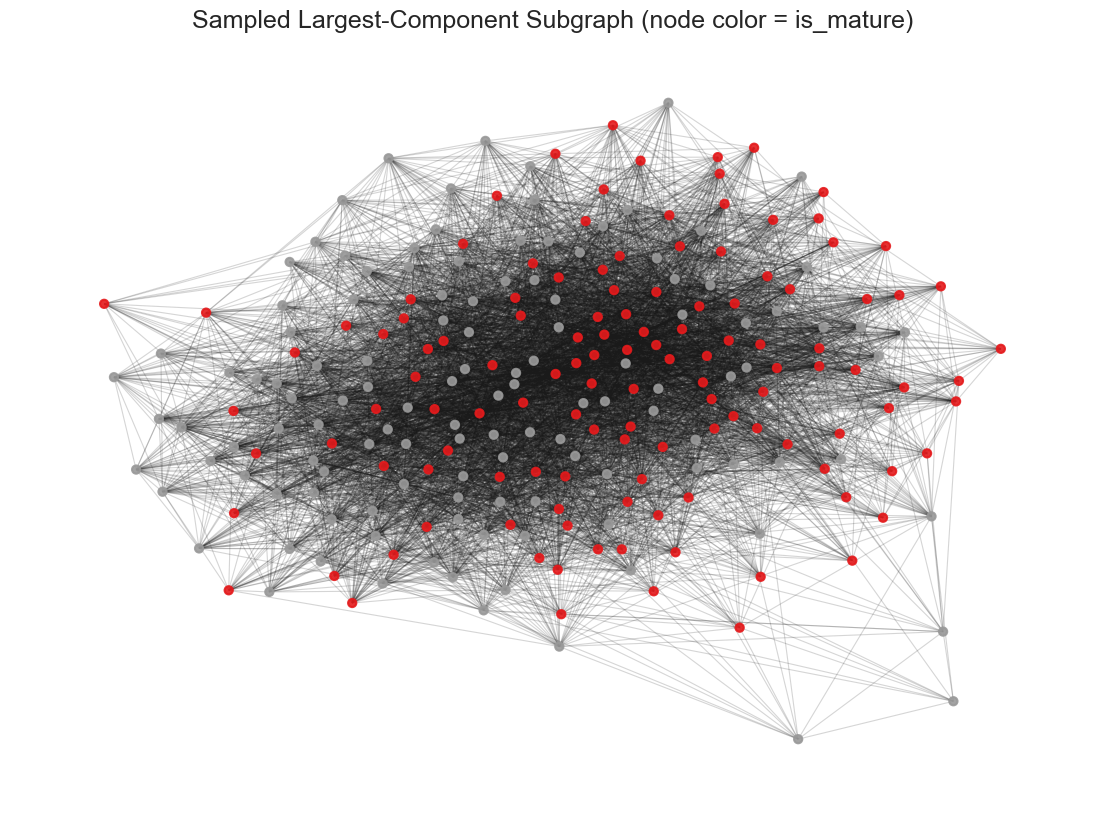

In [7]:
largest_cc_nodes = max(nx.connected_components(G), key=len)
G_lcc = G.subgraph(largest_cc_nodes).copy()

sample_size = min(250, G_lcc.number_of_nodes())
node_order = [n for n, _ in sorted(G_lcc.degree(), key=lambda x: x[1], reverse=True)]
sample_nodes = node_order[:sample_size]
H = G_lcc.subgraph(sample_nodes).copy()

pos = nx.spring_layout(H, seed=SEED, k=0.25)
node_colors = [G.nodes[n].get('is_mature', 0) for n in H.nodes()]

plt.figure(figsize=(14, 10))
nx.draw_networkx_edges(H, pos, alpha=0.18, width=0.8)
nx.draw_networkx_nodes(
    H,
    pos,
    node_color=node_colors,
    cmap=plt.cm.Set1,
    node_size=35,
    alpha=0.9,
)
plt.title('Sampled Largest-Component Subgraph (node color = is_mature)')
plt.axis('off')
plt.show()

## Task A: Node Attribute Prediction from Embeddings

### Pipeline
`Graph -> Embeddings (Spectral / Node2Vec) -> Classifier heads (SVM, RF, MLP, XGBoost, LightGBM) + Random baseline -> Metrics (Accuracy, Macro-F1) + Confusion Matrices`

### Design choices
- **SpectralEmbedding** captures global geometry through Laplacian structure.
- **Node2Vec** captures random-walk neighborhoods (local/mesoscopic structure), with optional `p/q` grid-search and persisted best config for fast reruns.
- **Multiple classifier heads** reduce model-selection bias when comparing embeddings.
- **Random baseline classifier** is included to show the gap versus learned models.
- **Best-per-embedding selection** (by macro-F1, then accuracy) is used for the final Spectral vs Node2Vec comparison plots.
- **Stratified split** keeps class proportions stable for fairer comparison.


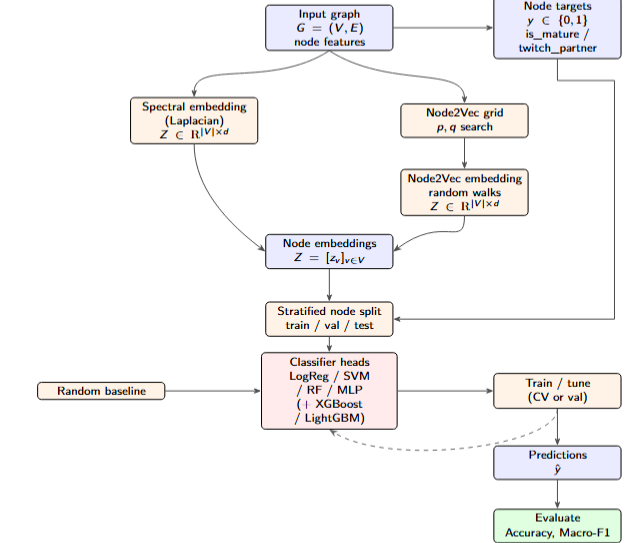

In [8]:
def get_spectral_embedding(graph, dim=32, seed=42):
    adj = nx.to_scipy_sparse_array(graph, format='csr', dtype=np.float64)
    adj = sp.csr_matrix(adj)
    adj.indices = adj.indices.astype(np.int32, copy=False)
    adj.indptr = adj.indptr.astype(np.int32, copy=False)

    se = SpectralEmbedding(
        n_components=dim,
        affinity='precomputed',
        random_state=seed,
    )
    emb = se.fit_transform(adj)
    return emb


def get_node2vec_embedding(graph, dim=32, p=1.0, q=0.5, walks=10, length=40, seed=42):
    if not HAVE_NODE2VEC:
        raise ImportError('node2vec package is not installed in this environment.')

    model = N2V_Algo(
        graph,
        dimensions=dim,
        walk_length=length,
        num_walks=walks,
        p=p,
        q=q,
        workers=1,
        quiet=True,
        seed=seed,
    ).fit(window=10, min_count=1, batch_words=4)

    nodes = list(graph.nodes())
    emb = np.array([model.wv[str(n)] for n in nodes])
    return emb, nodes


def project_to_2d(embeddings, seed=42):
    perplexity = max(5, min(30, (len(embeddings) - 1) // 3))
    tsne = TSNE(n_components=2, random_state=seed, init='pca', learning_rate='auto', perplexity=perplexity)
    return tsne.fit_transform(embeddings)

### Node2Vec Hyperparameter Grid (p, q)

Before comparing Spectral vs Node2Vec, we run a compact Node2Vec grid:
- `p in {0.25, 1.0, 4.0}`
- `q in {0.25, 1.0, 4.0}`

For each `(p, q)` pair, we train/evaluate a simple Logistic Regression on both node targets (`is_mature`, `twitch_partner`) and summarize performance in matrix heatmaps. We then keep the **best Node2Vec configuration** (highest average macro-F1 across both targets) for all final comparison plots.

In [9]:
print('Computing Spectral embeddings...')
emb_spectral = get_spectral_embedding(G, dim=32, seed=SEED)
nodes_ref = list(G.nodes())

labels_for_search = {
    'is_mature': np.array([G.nodes[n]['is_mature'] for n in nodes_ref], dtype=int),
    'twitch_partner': np.array([G.nodes[n]['twitch_partner'] for n in nodes_ref], dtype=int),
}

embeddings_by_method = {'Spectral': emb_spectral}

# Keep this as False to avoid recomputing the Node2Vec p/q grid every run.
RUN_NODE2VEC_GRIDSEARCH = False

# Persisted best config from earlier grid search runs.
NODE2VEC_DEFAULT_BEST_CONFIG = {
    'p': 1.0,
    'q': 0.25,
    'combined_macro_f1': 0.732,
}

NODE2VEC_GRID_P_VALUES = [0.25, 1.0, 4.0]
NODE2VEC_GRID_Q_VALUES = [0.25, 1.0, 4.0]

node2vec_best_config = NODE2VEC_DEFAULT_BEST_CONFIG.copy()
node2vec_grid_df = None

if HAVE_NODE2VEC:
    if RUN_NODE2VEC_GRIDSEARCH:
        grid_rows = []
        best_score = -np.inf
        best_embedding = None

        for p in NODE2VEC_GRID_P_VALUES:
            for q in NODE2VEC_GRID_Q_VALUES:
                print(f'Node2Vec grid run -> p={p}, q={q}')
                emb_n2v, n2v_nodes = get_node2vec_embedding(
                    G,
                    dim=32,
                    p=p,
                    q=q,
                    walks=10,
                    length=40,
                    seed=SEED,
                )

                if n2v_nodes != nodes_ref:
                    idx_map = {n: i for i, n in enumerate(n2v_nodes)}
                    emb_n2v = np.vstack([emb_n2v[idx_map[n]] for n in nodes_ref])

                target_scores = {}
                for target_name, y in labels_for_search.items():
                    X_train, X_test, y_train, y_test = train_test_split(
                        emb_n2v,
                        y,
                        test_size=0.2,
                        random_state=SEED,
                        stratify=y,
                    )
                    clf = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=SEED)
                    clf.fit(X_train, y_train)
                    y_pred = clf.predict(X_test)
                    target_scores[target_name] = f1_score(y_test, y_pred, average='macro', zero_division=0)

                combined_macro_f1 = float(np.mean(list(target_scores.values())))
                grid_rows.append(
                    {
                        'p': float(p),
                        'q': float(q),
                        'macro_f1_is_mature': target_scores['is_mature'],
                        'macro_f1_twitch_partner': target_scores['twitch_partner'],
                        'combined_macro_f1': combined_macro_f1,
                    }
                )

                if combined_macro_f1 > best_score:
                    best_score = combined_macro_f1
                    best_embedding = emb_n2v
                    node2vec_best_config = {
                        'p': float(p),
                        'q': float(q),
                        'combined_macro_f1': combined_macro_f1,
                    }

        node2vec_grid_df = pd.DataFrame(grid_rows).sort_values('combined_macro_f1', ascending=False).reset_index(drop=True)
        display(node2vec_grid_df)

        fig, axes = plt.subplots(1, 3, figsize=(21, 5))
        heatmap_specs = [
            ('macro_f1_is_mature', 'Node2Vec p/q Matrix: Macro-F1 (is_mature)'),
            ('macro_f1_twitch_partner', 'Node2Vec p/q Matrix: Macro-F1 (twitch_partner)'),
            ('combined_macro_f1', 'Node2Vec p/q Matrix: Combined Macro-F1'),
        ]

        for ax, (metric, title) in zip(axes, heatmap_specs):
            pivot = node2vec_grid_df.pivot(index='p', columns='q', values=metric)
            pivot = pivot.sort_index(ascending=False)
            sns.heatmap(pivot, annot=True, fmt='.3f', cmap='YlGnBu', ax=ax)
            ax.set_title(title)
            ax.set_xlabel('q')
            ax.set_ylabel('p')

        plt.tight_layout()
        plt.show()

        print(
            'Best Node2Vec config selected: '
            f"p={node2vec_best_config['p']}, q={node2vec_best_config['q']} "
            f"(combined macro-F1={node2vec_best_config['combined_macro_f1']:.3f})"
        )

    else:
        print('Skipping Node2Vec p/q grid search (RUN_NODE2VEC_GRIDSEARCH=False).')
        print(
            'Using persisted Node2Vec config: '
            f"p={node2vec_best_config['p']}, q={node2vec_best_config['q']} "
            f"(combined macro-F1={node2vec_best_config['combined_macro_f1']:.3f})"
        )

    if not RUN_NODE2VEC_GRIDSEARCH:
        emb_n2v, n2v_nodes = get_node2vec_embedding(
            G,
            dim=32,
            p=node2vec_best_config['p'],
            q=node2vec_best_config['q'],
            walks=10,
            length=40,
            seed=SEED,
        )
        if n2v_nodes != nodes_ref:
            idx_map = {n: i for i, n in enumerate(n2v_nodes)}
            emb_n2v = np.vstack([emb_n2v[idx_map[n]] for n in nodes_ref])
        best_embedding = emb_n2v

    embeddings_by_method['Node2Vec'] = best_embedding
else:
    print('Node2Vec is not available in this environment. Skipping p/q grid search.')

for name, emb in embeddings_by_method.items():
    print(f'{name}: {emb.shape}')


Computing Spectral embeddings...
Skipping Node2Vec p/q grid search (RUN_NODE2VEC_GRIDSEARCH=False).
Using persisted Node2Vec config: p=1.0, q=0.25 (combined macro-F1=0.732)
Spectral: (1912, 32)
Node2Vec: (1912, 32)


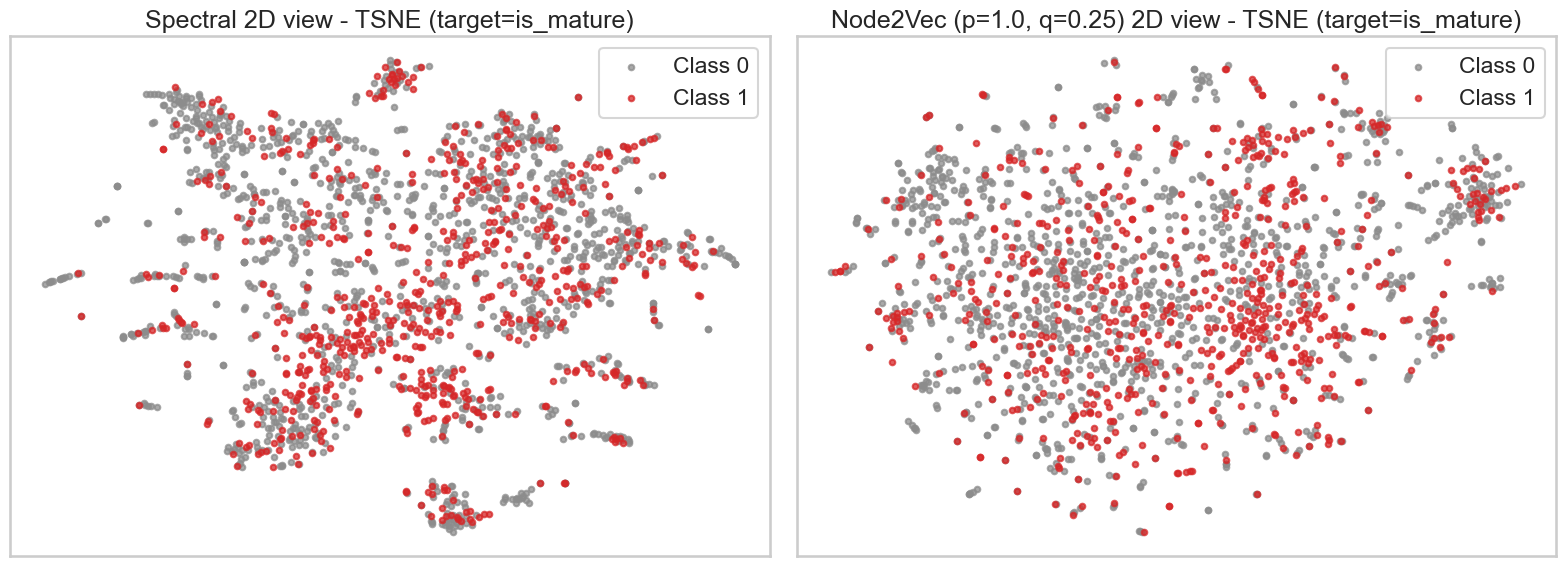

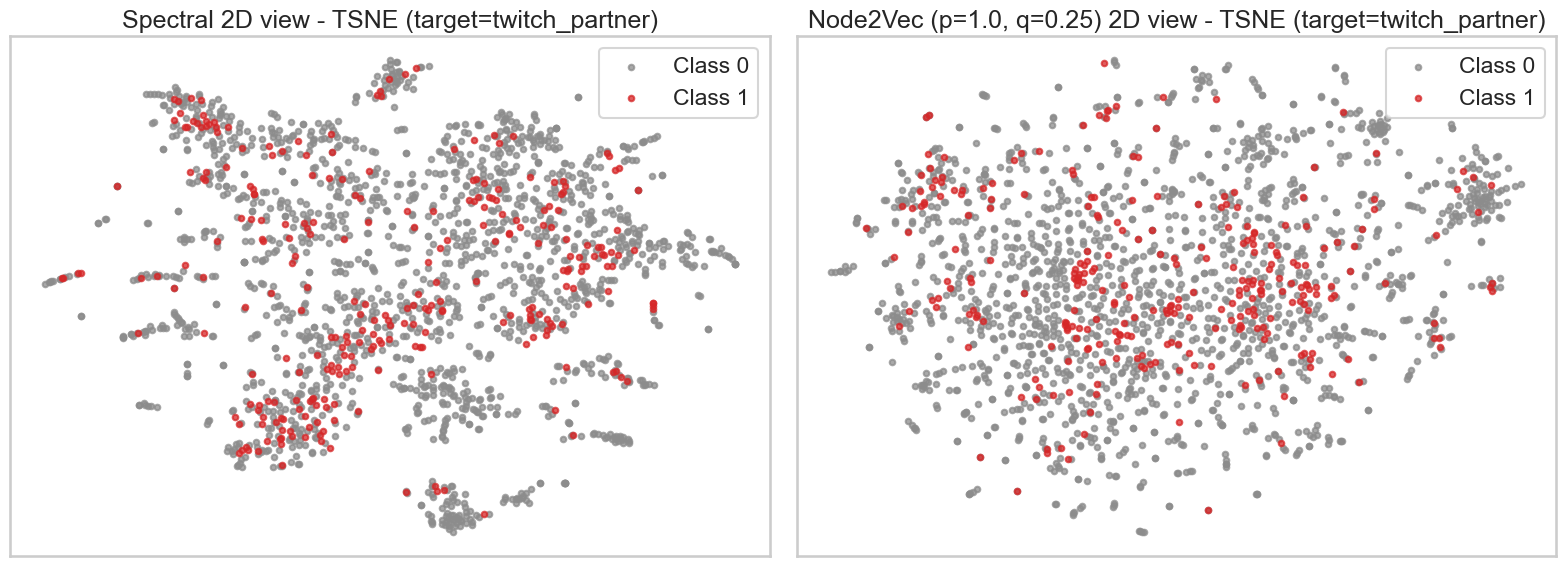

In [10]:
labels_by_target = {
    'is_mature': np.array([G.nodes[n]['is_mature'] for n in nodes_ref], dtype=int),
    'twitch_partner': np.array([G.nodes[n]['twitch_partner'] for n in nodes_ref], dtype=int),
}

emb_2d = {name: project_to_2d(emb, seed=SEED) for name, emb in embeddings_by_method.items()}
class_colors = {0: '#8c8c8c', 1: '#d62728'}

for target_name, labels in labels_by_target.items():
    fig, axes = plt.subplots(1, len(emb_2d), figsize=(8 * len(emb_2d), 6), squeeze=False)
    for j, (method_name, emb2d) in enumerate(emb_2d.items()):
        ax = axes[0, j]
        for cls in [0, 1]:
            mask = labels == cls
            if np.any(mask):
                ax.scatter(
                    emb2d[mask, 0],
                    emb2d[mask, 1],
                    color=class_colors[cls],
                    s=16,
                    alpha=0.75,
                    label=f'Class {cls}',
                )

        title_suffix = ''
        if method_name == 'Node2Vec' and node2vec_best_config is not None:
            title_suffix = f" (p={node2vec_best_config['p']}, q={node2vec_best_config['q']})"

        ax.set_title(f'{method_name}{title_suffix} 2D view - TSNE (target={target_name})')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.legend(loc='best', frameon=True)

    plt.tight_layout()
    plt.show()

All classifier results (with random baseline):


,target,embedding,classifier,accuracy,macro_f1,macro_precision,macro_recall
0,is_mature,Node2Vec,SVM (RBF Kernel),0.676240,0.640343,0.640879,0.639850
1,is_mature,Node2Vec,LightGBM,0.663185,0.582940,0.610703,0.583198
2,is_mature,Node2Vec,MLP (Neural Net),0.637076,0.579237,0.586135,0.577644
3,is_mature,Node2Vec,XGBoost,0.668407,0.553969,0.617022,0.565631
4,is_mature,Node2Vec,Random Forest,0.691906,0.553948,0.688482,0.574580
5,is_mature,Random Baseline,Random Classifier,0.548303,0.493483,0.493581,0.493752
6,is_mature,Spectral,Random Forest,0.723238,0.634147,0.717767,0.630810
7,is_mature,Spectral,XGBoost,0.691906,0.621694,0.652651,0.617681
8,is_mature,Spectral,SVM (RBF Kernel),0.647520,0.617071,0.615589,0.619733
9,is_mature,Spectral,MLP (Neural Net),0.652742,0.614942,0.615155,0.614738


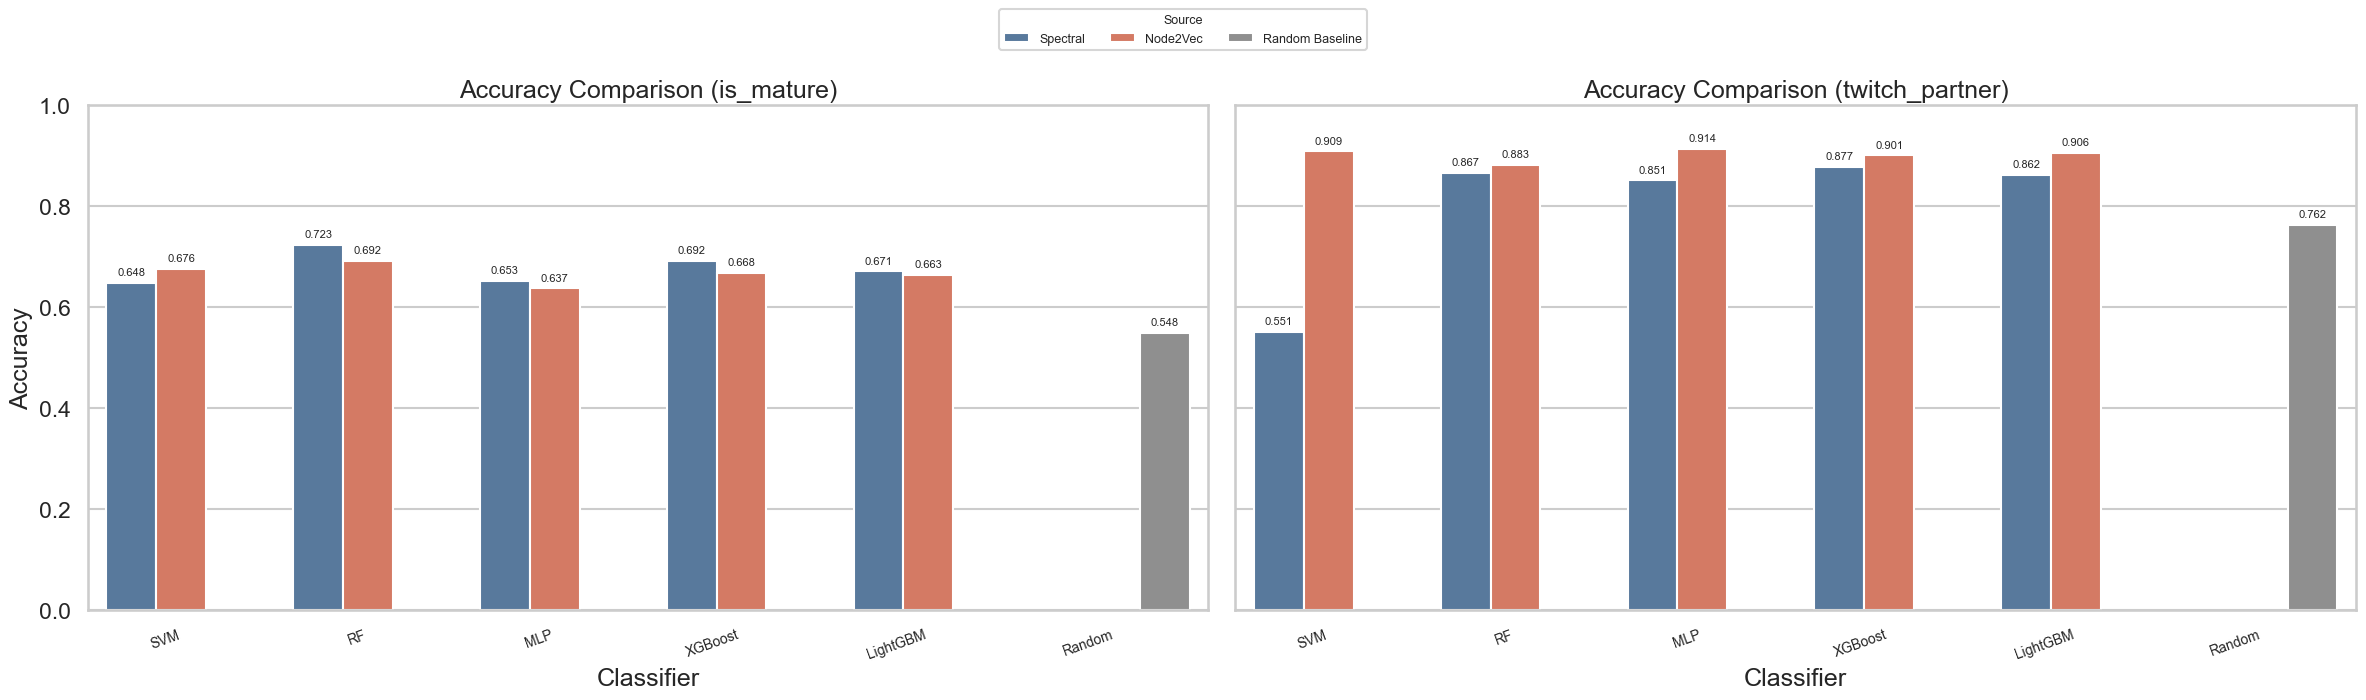

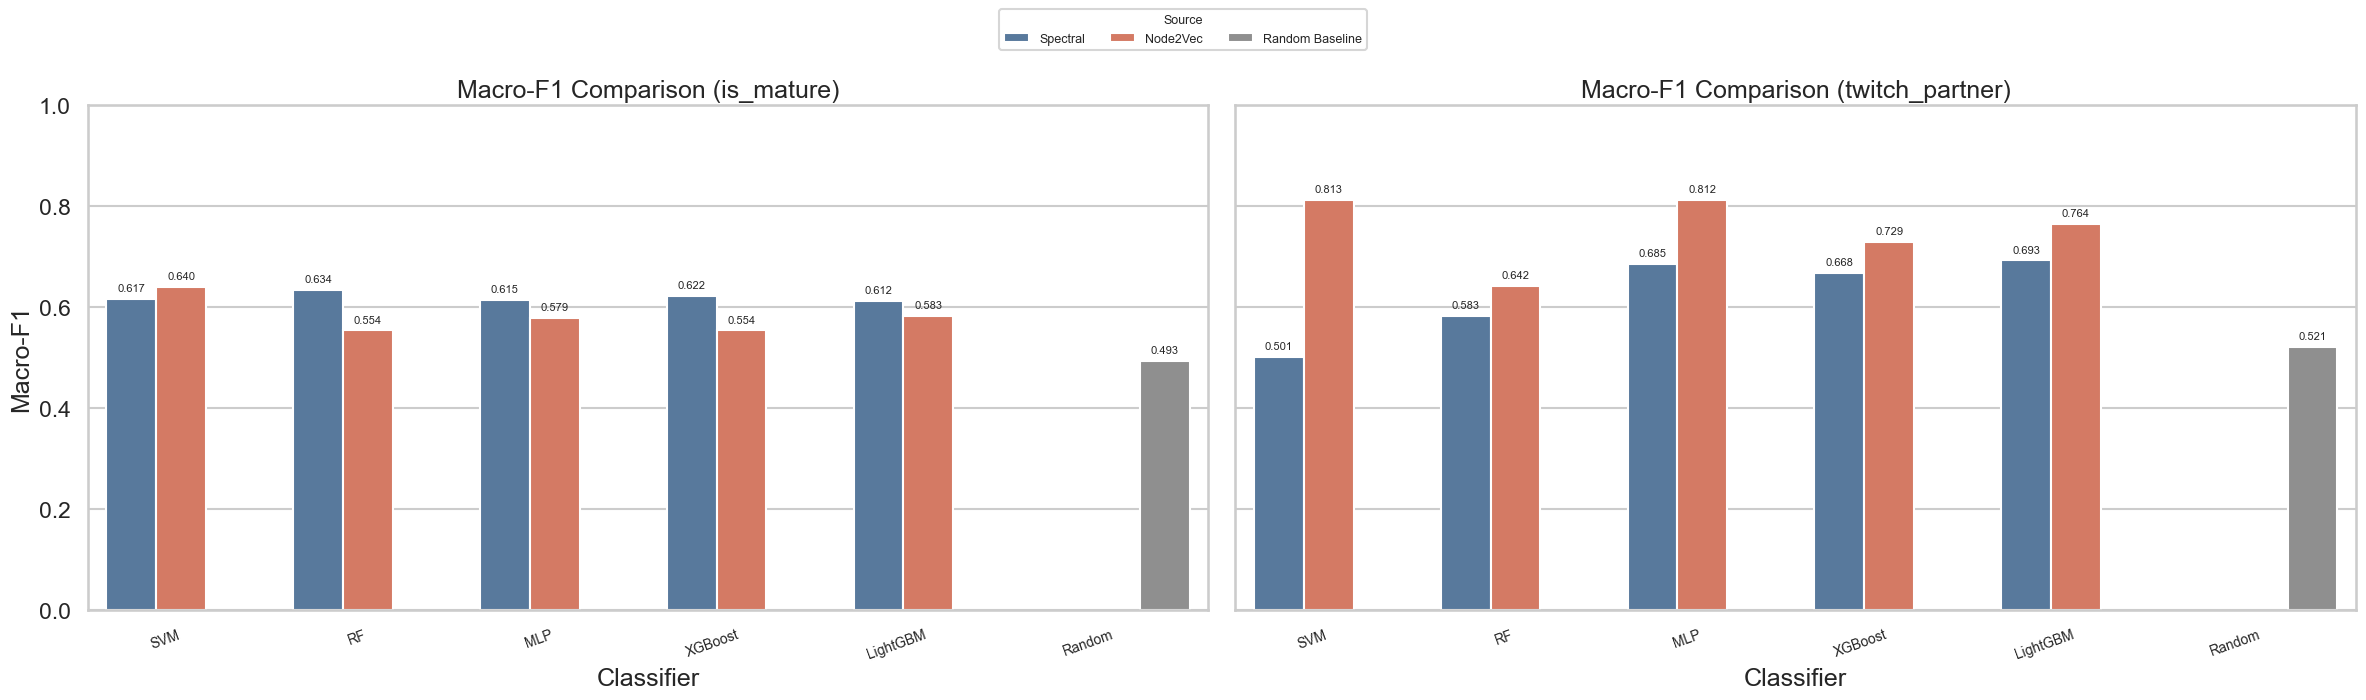

Best classifier per embedding (used for Spectral vs Node2Vec plots):


,target,embedding,classifier,accuracy,macro_f1
0,is_mature,Node2Vec,SVM (RBF Kernel),0.676240,0.640343
1,is_mature,Spectral,Random Forest,0.723238,0.634147
2,twitch_partner,Node2Vec,SVM (RBF Kernel),0.908616,0.812813
3,twitch_partner,Spectral,LightGBM,0.861619,0.692593


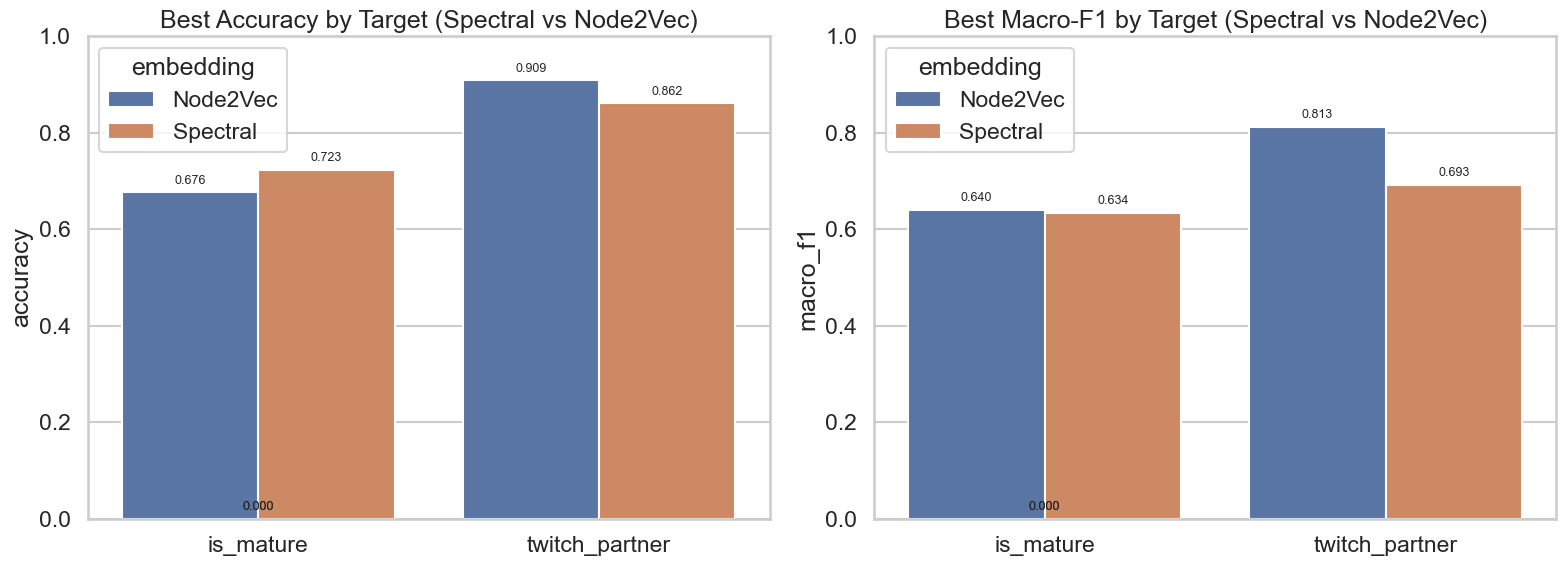

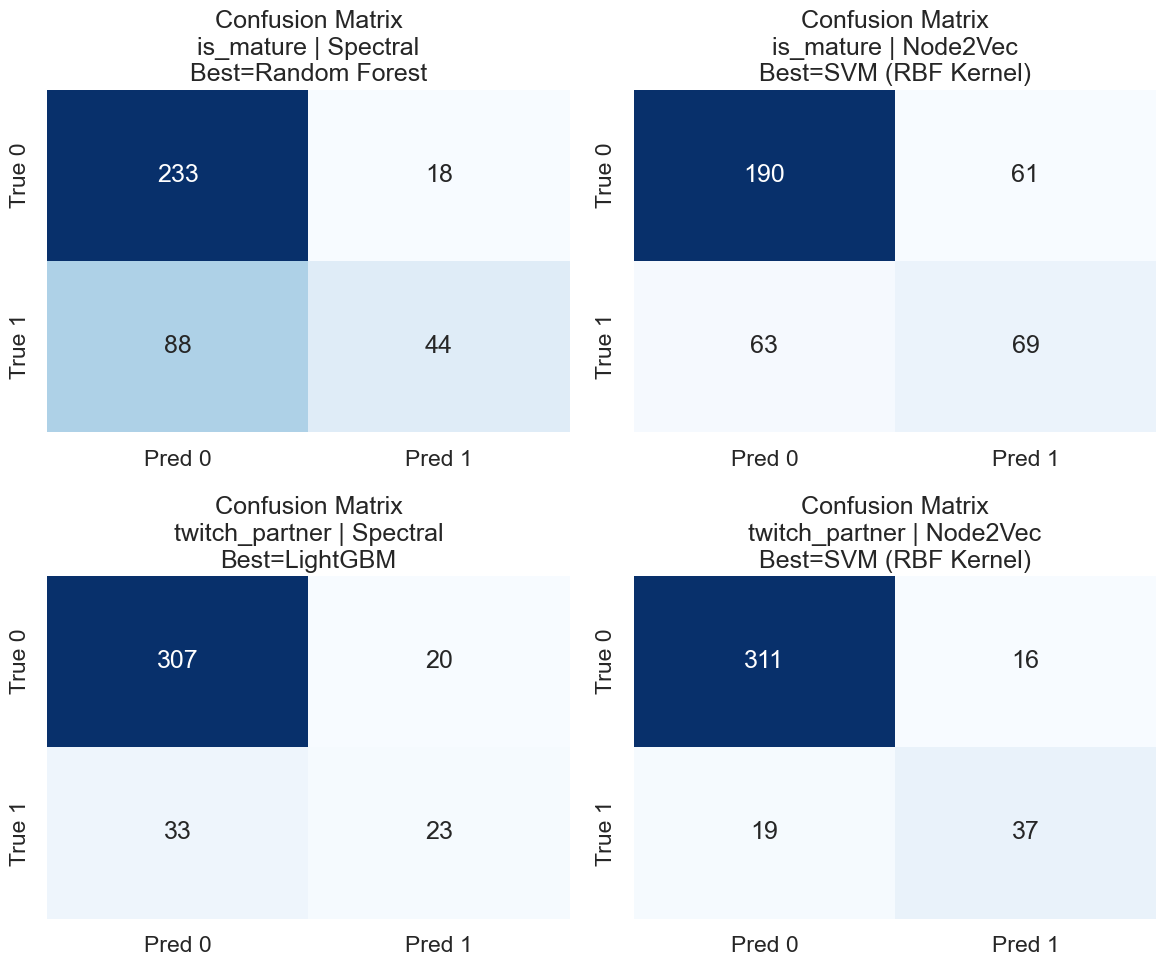

In [11]:
def build_classifier_heads(seed=42):
    models = {
        'SVM (RBF Kernel)': make_pipeline(
            StandardScaler(),
            SVC(kernel='rbf', C=2.0, gamma='scale', class_weight='balanced', random_state=seed),
        ),
        'Random Forest': RandomForestClassifier(
            random_state=seed,
            n_estimators=300,
            class_weight='balanced_subsample',
            n_jobs=-1,
        ),
        'MLP (Neural Net)': make_pipeline(
            StandardScaler(),
            MLPClassifier(random_state=seed, max_iter=1200, hidden_layer_sizes=(128, 64)),
        ),
    }

    if HAVE_XGBOOST:
        models['XGBoost'] = XGBClassifier(
            random_state=seed,
            n_estimators=250,
            max_depth=6,
            learning_rate=0.05,
            subsample=0.9,
            colsample_bytree=0.9,
            objective='binary:logistic',
            eval_metric='logloss',
            n_jobs=-1,
        )

    if HAVE_LIGHTGBM:
        models['LightGBM'] = LGBMClassifier(
            random_state=seed,
            n_estimators=300,
            learning_rate=0.05,
            num_leaves=31,
            subsample=0.9,
            colsample_bytree=0.9,
            class_weight='balanced',
            verbose=-1,
        )

    return models


def evaluate_multiple_classifiers(G, embeddings, target_attr, embedding_name, classifier_heads, seed=42):
    nodes = list(G.nodes())
    y_all = np.array([G.nodes[n].get(target_attr) for n in nodes], dtype=object)
    valid_mask = np.array([label is not None for label in y_all], dtype=bool)

    X = embeddings[valid_mask]
    y = y_all[valid_mask].astype(int)

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=seed,
        stratify=y,
    )

    overall_rows = []
    per_class_rows = []
    pred_by_classifier = {}

    for clf_name, clf in classifier_heads.items():
        model = clone(clf)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        pred_by_classifier[clf_name] = y_pred

        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

        method_name = f'{embedding_name} | {clf_name}'
        overall_rows.append(
            {
                'target': target_attr,
                'embedding': embedding_name,
                'classifier': clf_name,
                'method': method_name,
                'accuracy': accuracy_score(y_test, y_pred),
                'macro_f1': f1_score(y_test, y_pred, average='macro', zero_division=0),
                'macro_precision': precision_score(y_test, y_pred, average='macro', zero_division=0),
                'macro_recall': recall_score(y_test, y_pred, average='macro', zero_division=0),
            }
        )

        for cls in ['0', '1']:
            if cls in report:
                per_class_rows.append(
                    {
                        'target': target_attr,
                        'embedding': embedding_name,
                        'classifier': clf_name,
                        'method': method_name,
                        'class': int(cls),
                        'precision': report[cls]['precision'],
                        'recall': report[cls]['recall'],
                        'f1-score': report[cls]['f1-score'],
                        'support': report[cls]['support'],
                    }
                )

    return overall_rows, per_class_rows, y_test, pred_by_classifier


def evaluate_random_baseline(G, target_attr, seed=42):
    nodes = list(G.nodes())
    y_all = np.array([G.nodes[n].get(target_attr) for n in nodes], dtype=object)
    valid_mask = np.array([label is not None for label in y_all], dtype=bool)
    y = y_all[valid_mask].astype(int)

    X_dummy = np.zeros((len(y), 1), dtype=np.float32)
    X_train, X_test, y_train, y_test = train_test_split(
        X_dummy,
        y,
        test_size=0.2,
        random_state=seed,
        stratify=y,
    )

    clf = DummyClassifier(strategy='stratified', random_state=seed)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    method_name = 'Random Baseline | Random Classifier'

    overall = {
        'target': target_attr,
        'embedding': 'Random Baseline',
        'classifier': 'Random Classifier',
        'method': method_name,
        'accuracy': accuracy_score(y_test, y_pred),
        'macro_f1': f1_score(y_test, y_pred, average='macro', zero_division=0),
        'macro_precision': precision_score(y_test, y_pred, average='macro', zero_division=0),
        'macro_recall': recall_score(y_test, y_pred, average='macro', zero_division=0),
    }

    per_class = []
    for cls in ['0', '1']:
        if cls in report:
            per_class.append(
                {
                    'target': target_attr,
                    'embedding': 'Random Baseline',
                    'classifier': 'Random Classifier',
                    'method': method_name,
                    'class': int(cls),
                    'precision': report[cls]['precision'],
                    'recall': report[cls]['recall'],
                    'f1-score': report[cls]['f1-score'],
                    'support': report[cls]['support'],
                }
            )

    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    return overall, per_class, cm


classifier_heads = build_classifier_heads(seed=SEED)
if not HAVE_XGBOOST:
    print('XGBoost is not available, skipping that classifier head.')
if not HAVE_LIGHTGBM:
    print('LightGBM is not available, skipping that classifier head.')

all_overall_rows = []
all_class_rows = []
conf_mats = {}

for target_name in labels_by_target.keys():
    for embedding_name, emb in embeddings_by_method.items():
        overall_rows, per_class_rows, y_test, pred_by_classifier = evaluate_multiple_classifiers(
            G,
            emb,
            target_attr=target_name,
            embedding_name=embedding_name,
            classifier_heads=classifier_heads,
            seed=SEED,
        )
        all_overall_rows.extend(overall_rows)
        all_class_rows.extend(per_class_rows)

        for clf_name, y_pred in pred_by_classifier.items():
            conf_mats[(target_name, embedding_name, clf_name)] = confusion_matrix(y_test, y_pred, labels=[0, 1])

    baseline_overall, baseline_per_class, baseline_cm = evaluate_random_baseline(G, target_name, seed=SEED)
    all_overall_rows.append(baseline_overall)
    all_class_rows.extend(baseline_per_class)
    conf_mats[(target_name, 'Random Baseline', 'Random Classifier')] = baseline_cm

overall_df = pd.DataFrame(all_overall_rows).sort_values(
    ['target', 'embedding', 'macro_f1', 'accuracy'],
    ascending=[True, True, False, False],
).reset_index(drop=True)
class_df = pd.DataFrame(all_class_rows).sort_values(['target', 'method', 'class']).reset_index(drop=True)

print('All classifier results (with random baseline):')
display(
    overall_df[
        ['target', 'embedding', 'classifier', 'accuracy', 'macro_f1', 'macro_precision', 'macro_recall']
    ]
)

plot_targets = [t for t in ['is_mature', 'twitch_partner'] if t in set(overall_df['target'])]
if plot_targets:
    color_map = {
        'Spectral': '#4C78A8',
        'Node2Vec': '#E76F51',
        'Random Baseline': '#8F8F8F',
    }
    hue_order = ['Spectral', 'Node2Vec', 'Random Baseline']
    clf_label_map = {
        'SVM (RBF Kernel)': 'SVM',
        'Random Forest': 'RF',
        'MLP (Neural Net)': 'MLP',
        'Random Classifier': 'Random',
        'XGBoost': 'XGBoost',
        'LightGBM': 'LightGBM',
    }
    clf_order = ['SVM', 'RF', 'MLP', 'XGBoost', 'LightGBM', 'Random']

    metric_specs = [
        ('accuracy', 'Accuracy', 'Accuracy Comparison'),
        ('macro_f1', 'Macro-F1', 'Macro-F1 Comparison'),
    ]

    for metric_col, y_label, title_prefix in metric_specs:
        fig, axes = plt.subplots(1, len(plot_targets), figsize=(12 * len(plot_targets), 7), sharey=True)
        if len(plot_targets) == 1:
            axes = [axes]

        for i, target_name in enumerate(plot_targets):
            ax = axes[i]
            plot_df = overall_df[overall_df['target'] == target_name].copy()
            plot_df['classifier_short'] = plot_df['classifier'].map(lambda x: clf_label_map.get(x, x))

            sns.barplot(
                data=plot_df,
                x='classifier_short',
                y=metric_col,
                hue='embedding',
                order=[c for c in clf_order if c in set(plot_df['classifier_short'])],
                hue_order=[h for h in hue_order if h in set(plot_df['embedding'])],
                palette=color_map,
                dodge=True,
                ax=ax,
            )

            ax.set_title(f'{title_prefix} ({target_name})')
            ax.set_xlabel('Classifier')
            ax.set_ylabel(y_label)
            ax.set_ylim(0, 1)
            ax.tick_params(axis='x', labelrotation=20)
            for label in ax.get_xticklabels():
                label.set_ha('right')
                label.set_fontsize(10)

            for p in ax.patches:
                height = p.get_height()
                if np.isfinite(height) and height > 0:
                    ax.annotate(
                        f'{height:.3f}',
                        (p.get_x() + p.get_width() / 2.0, height),
                        ha='center',
                        va='bottom',
                        xytext=(0, 4),
                        textcoords='offset points',
                        fontsize=8,
                    )

        handles, labels = axes[0].get_legend_handles_labels()
        for ax in axes:
            legend = ax.get_legend()
            if legend is not None:
                legend.remove()

        fig.legend(
            handles,
            labels,
            title='Source',
            loc='upper center',
            bbox_to_anchor=(0.5, 1.02),
            ncol=3,
            fontsize=9,
            title_fontsize=9,
            frameon=True,
        )

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

comparison_df = overall_df[overall_df['embedding'].isin(['Spectral', 'Node2Vec'])].copy()
best_models_df = (
    comparison_df.sort_values(
        ['target', 'embedding', 'macro_f1', 'accuracy'],
        ascending=[True, True, False, False],
    )
    .groupby(['target', 'embedding'], as_index=False)
    .first()
)

print('Best classifier per embedding (used for Spectral vs Node2Vec plots):')
display(best_models_df[['target', 'embedding', 'classifier', 'accuracy', 'macro_f1']])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(data=best_models_df, x='target', y='accuracy', hue='embedding', ax=axes[0])
axes[0].set_title('Best Accuracy by Target (Spectral vs Node2Vec)')
axes[0].set_ylim(0, 1)
axes[0].set_xlabel('')

sns.barplot(data=best_models_df, x='target', y='macro_f1', hue='embedding', ax=axes[1])
axes[1].set_title('Best Macro-F1 by Target (Spectral vs Node2Vec)')
axes[1].set_ylim(0, 1)
axes[1].set_xlabel('')

for ax in axes:
    for p in ax.patches:
        height = p.get_height()
        if np.isfinite(height):
            ax.annotate(
                f'{height:.3f}',
                (p.get_x() + p.get_width() / 2.0, height),
                ha='center',
                va='bottom',
                xytext=(0, 4),
                textcoords='offset points',
                fontsize=9,
            )

plt.tight_layout()
plt.show()

embedding_order = [name for name in ['Spectral', 'Node2Vec'] if name in comparison_df['embedding'].unique()]
target_order = sorted(best_models_df['target'].unique())
fig, axes = plt.subplots(len(target_order), len(embedding_order), figsize=(6 * len(embedding_order), 5 * len(target_order)), squeeze=False)

for i, target_name in enumerate(target_order):
    for j, embedding_name in enumerate(embedding_order):
        ax = axes[i, j]
        row = best_models_df[
            (best_models_df['target'] == target_name) & (best_models_df['embedding'] == embedding_name)
        ]

        if row.empty:
            ax.axis('off')
            continue

        clf_name = row.iloc[0]['classifier']
        cm = conf_mats[(target_name, embedding_name, clf_name)]

        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            cbar=False,
            xticklabels=['Pred 0', 'Pred 1'],
            yticklabels=['True 0', 'True 1'],
            ax=ax,
        )
        ax.set_title(f'Confusion Matrix\n{target_name} | {embedding_name}\nBest={clf_name}')

plt.tight_layout()
plt.show()


Results (Task A: Attribute Classification):
- is_mature: best accuracy is Spectral + Random Forest (0.723).
- is_mature: best macro-F1 is Node2Vec + SVM (RBF Kernel) (0.640).
- is_mature: why this likely worked -> embedding reason: captures local random-walk neighborhoods and homophily, which helps node-attribute separability. classifier reason: the margin-based decision boundary (with RBF kernel) handles non-linear class boundaries well.
- is_mature: gain vs random baseline -> accuracy +0.175, macro-F1 +0.147.
-
- twitch_partner: best accuracy is Node2Vec + MLP (Neural Net) (0.914).
- twitch_partner: best macro-F1 is Node2Vec + SVM (RBF Kernel) (0.813).
- twitch_partner: why this likely worked -> embedding reason: captures local random-walk neighborhoods and homophily, which helps node-attribute separability. classifier reason: the margin-based decision boundary (with RBF kernel) handles non-linear class boundaries well.
- twitch_partner: gain vs random baseline -> accuracy +0.151, macro-F1 +0.292.

### Task A1 Conclusions (Attribute Classification)

The strongest **class-balanced** model is **Node2Vec + SVM (RBF)** for both targets:

- **is_mature**: macro-F1 = 0.640, accuracy = 0.676  
- **twitch_partner**: macro-F1 = 0.813, accuracy = 0.909  

The strongest **accuracy-only** model is not always the same:

- **is_mature**: Spectral + Random Forest has highest accuracy (0.723), but lower macro-F1 (0.634) than Node2Vec + SVM.  
- **twitch_partner**: Node2Vec + MLP has highest accuracy (0.914), but Node2Vec + SVM is slightly better on macro-F1.  

**Why Node2Vec + SVM works well:**

- Node2Vec captures local neighborhood / homophily patterns that are important for attribute prediction.  
- RBF-SVM handles non-linear class boundaries in embedding space better than linear/simple baselines.  
- This combination gives better minority-class behavior (higher macro-F1), not just better majority-class accuracy.  

**Confusion matrix insight (minority class = class 1):**

- **is_mature**: Node2Vec + SVM finds many more class-1 nodes than Spectral + RF (69 TP vs 44 TP), with higher class-1 recall.  
- **twitch_partner**: Node2Vec + SVM also improves class-1 detection over Spectral + LightGBM (37 TP vs 23 TP), with fewer missed positives.  

Compared with a random baseline, all learned models are clearly better:

- **is_mature**: random baseline macro-F1 = 0.493  
- **twitch_partner**: random baseline macro-F1 = 0.521  

**Recommended default for reporting:**

- Use **Node2Vec + SVM (RBF)** as the main model when balanced performance is the goal.  
- Mention **Spectral + RF** (*is_mature*) and **Node2Vec + MLP** (*twitch_partner*) as best-accuracy alternatives.

## Task A2: Link Prediction with Embedding Similarity

This adds a **simple embedding-based link prediction baseline** (no GNN message passing):
`Train graph -> Embedding -> Similarity score -> Rank candidate edges -> ROC-AUC + Average Precision + Accuracy@0.5`

### Similarity measures (method-specific)
- **Node2Vec** (skip-gram): use **dot-product** similarity `s(u,v) = z_u^T z_v` (often paired with `sigmoid` for a probability-like score).
- **Spectral embedding**: use **distance** in the embedded space; we score as `s(u,v) = -||z_u - z_v||^2` so *closer nodes rank higher*.

We avoid leakage by computing embeddings on a **train-only graph** (holding out a test edge set).


In [12]:
def edge_split_connected(graph, test_frac=0.2, seed=42):
    """Connected train graph via DFS spanning tree + random held-out edges."""
    rng = random.Random(seed)
    edges = [tuple(e) for e in graph.edges()]
    # build a spanning tree so train graph stays connected
    start = next(iter(graph.nodes()))
    tree_edges = [tuple(e) for e in nx.dfs_edges(graph, source=start)]
    tree_set = {tuple(sorted(e)) for e in tree_edges}
    edge_set = {tuple(sorted(e)) for e in edges}
    remaining = list(edge_set - tree_set)
    rng.shuffle(remaining)

    n_test = int(round(test_frac * len(edge_set)))
    n_test = min(n_test, len(remaining))
    test_edges = remaining[:n_test]
    train_edges = list(tree_set) + remaining[n_test:]

    g_train = nx.Graph()
    g_train.add_nodes_from(graph.nodes())
    g_train.add_edges_from(train_edges)
    return g_train, train_edges, test_edges


def sample_negative_edges(graph_full, n_samples, seed=42):
    rng = random.Random(seed)
    nodes = list(graph_full.nodes())
    negatives = set()
    while len(negatives) < n_samples:
        u = rng.choice(nodes)
        v = rng.choice(nodes)
        if u == v:
            continue
        e = (u, v)
        e = tuple(sorted(e))
        if graph_full.has_edge(*e):
            continue
        negatives.add(e)
    return list(negatives)


def spectral_embedding_with_nodes(graph, dim=32, seed=42):
    nodes = list(graph.nodes())
    adj = nx.to_scipy_sparse_array(graph, nodelist=nodes, format='csr', dtype=np.float64)
    adj = sp.csr_matrix(adj)
    adj.indices = adj.indices.astype(np.int32, copy=False)
    adj.indptr = adj.indptr.astype(np.int32, copy=False)
    se = SpectralEmbedding(n_components=dim, affinity='precomputed', random_state=seed)
    emb = se.fit_transform(adj)
    return emb, nodes


def sigmoid(x):
    x = np.clip(x, -20, 20)
    return 1.0 / (1.0 + np.exp(-x))


def make_emb_map(emb, nodes):
    return {n: emb[i] for i, n in enumerate(nodes)}


def score_pairs(pairs, emb_map, method):
    scores = np.empty(len(pairs), dtype=np.float64)
    for i, (u, v) in enumerate(pairs):
        zu = emb_map[u]
        zv = emb_map[v]
        if method == "Node2Vec":
            scores[i] = float(np.dot(zu, zv))
        elif method == "Spectral":
            d = zu - zv
            scores[i] = -float(np.dot(d, d))
        else:
            raise ValueError(f"Unknown method: {method}")
    return scores


G_train_lp, train_edges_lp, test_edges_lp = edge_split_connected(G, test_frac=0.2, seed=SEED)
neg_edges_lp = sample_negative_edges(G, n_samples=len(test_edges_lp), seed=SEED)

pairs_lp = list(test_edges_lp) + list(neg_edges_lp)
labels_lp = np.array([1] * len(test_edges_lp) + [0] * len(neg_edges_lp))

results_lp = []

# Spectral
emb_spec_lp, nodes_spec_lp = spectral_embedding_with_nodes(G_train_lp, dim=32, seed=SEED)
emb_map_spec = make_emb_map(emb_spec_lp, nodes_spec_lp)
raw_scores_spec = score_pairs(pairs_lp, emb_map_spec, method="Spectral")
probs_spec = sigmoid(raw_scores_spec)
pred_spec = (probs_spec >= 0.5).astype(int)
results_lp.append({
    "method": "Spectral",
    "roc_auc": roc_auc_score(labels_lp, probs_spec),
    "ap": average_precision_score(labels_lp, probs_spec),
    "accuracy": accuracy_score(labels_lp, pred_spec),
})

# Node2Vec
have_n2v = bool(globals().get("HAVE_NODE2VEC", False))
if have_n2v:
    cfg = globals().get("node2vec_best_config") or {"p": 1.0, "q": 1.0}
    emb_n2v_lp, nodes_n2v_lp = get_node2vec_embedding(
        G_train_lp,
        dim=32,
        p=cfg["p"],
        q=cfg["q"],
        walks=10,
        length=40,
        seed=SEED,
    )
    emb_map_n2v = make_emb_map(emb_n2v_lp, nodes_n2v_lp)
    raw_scores_n2v = score_pairs(pairs_lp, emb_map_n2v, method="Node2Vec")
    probs_n2v = sigmoid(raw_scores_n2v)
    pred_n2v = (probs_n2v >= 0.5).astype(int)
    results_lp.append({
        "method": f"Node2Vec (p={cfg['p']}, q={cfg['q']})",
        "roc_auc": roc_auc_score(labels_lp, probs_n2v),
        "ap": average_precision_score(labels_lp, probs_n2v),
        "accuracy": accuracy_score(labels_lp, pred_n2v),
    })
else:
    print("Node2Vec not available in this environment; skipping Node2Vec link prediction baseline.")

lp_df = pd.DataFrame(results_lp).sort_values(["ap", "accuracy"], ascending=False).reset_index(drop=True)
print("Embedding baseline metrics (accuracy uses threshold=0.5):")
display(lp_df)


Embedding baseline metrics (accuracy uses threshold=0.5):


,method,roc_auc,ap,accuracy
0,Spectral,0.789844,0.779025,0.500000
1,"Node2Vec (p=1.0, q=0.25)",0.591503,0.580459,0.516534


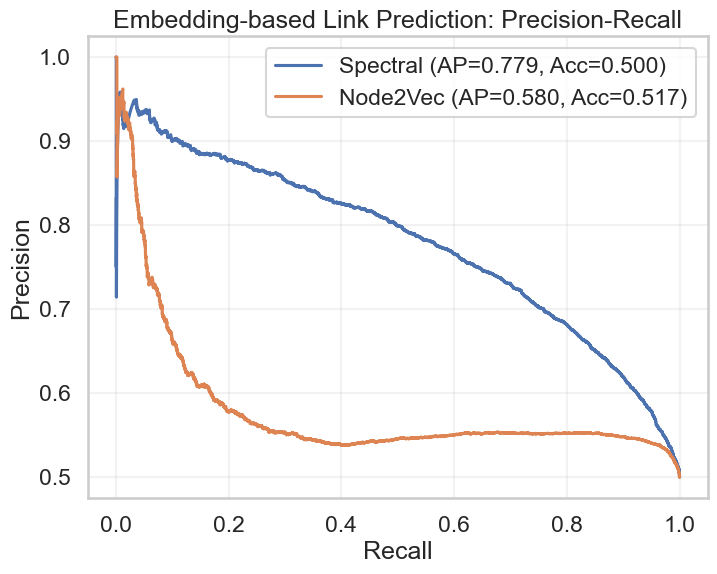

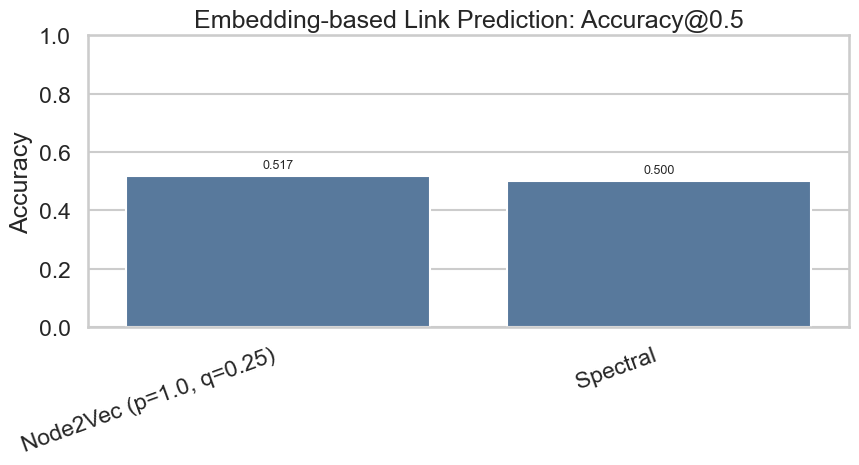

In [13]:
# Optional: PR curves for the embedding baselines
have_n2v = bool(globals().get("HAVE_NODE2VEC", False))
plt.figure(figsize=(8, 6))
prec, rec, _ = precision_recall_curve(labels_lp, probs_spec)
plt.plot(
    rec,
    prec,
    label=f"Spectral (AP={average_precision_score(labels_lp, probs_spec):.3f}, Acc={accuracy_score(labels_lp, (probs_spec >= 0.5).astype(int)):.3f})",
)

if have_n2v:
    prec, rec, _ = precision_recall_curve(labels_lp, probs_n2v)
    plt.plot(
        rec,
        prec,
        label=f"Node2Vec (AP={average_precision_score(labels_lp, probs_n2v):.3f}, Acc={accuracy_score(labels_lp, (probs_n2v >= 0.5).astype(int)):.3f})",
    )

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Embedding-based Link Prediction: Precision-Recall")
plt.legend()
plt.grid(alpha=0.25)
plt.show()

plt.figure(figsize=(9, 5))
acc_df = lp_df[["method", "accuracy"]].sort_values("accuracy", ascending=False)
ax = sns.barplot(data=acc_df, x="method", y="accuracy", color="#4C78A8")
ax.set_title("Embedding-based Link Prediction: Accuracy@0.5")
ax.set_xlabel("")
ax.set_ylabel("Accuracy")
ax.set_ylim(0, 1)
ax.tick_params(axis='x', labelrotation=20)
for label in ax.get_xticklabels():
    label.set_ha('right')

for p in ax.patches:
    h = p.get_height()
    if np.isfinite(h):
        ax.annotate(
            f"{h:.3f}",
            (p.get_x() + p.get_width() / 2.0, h),
            ha='center',
            va='bottom',
            xytext=(0, 4),
            textcoords='offset points',
            fontsize=9,
        )

plt.tight_layout()
plt.show()


## Task B: GraphSAGE Link Prediction

### Pipeline
`Relabel nodes -> Edge split (train/val/test, anti-leakage) -> Structural features from train graph -> GraphSAGE encoder + MLP scorer -> Early stopping on validation AP -> Test evaluation (ROC-AUC, AP, Accuracy@0.5)`

### Why these choices
- **Anti-leakage split** prevents val/test edges from influencing message passing.
- **Structural features** (degree, clustering, core number, PageRank) keep the task graph-centric and reproducible.
- **ROC-AUC + Average Precision + Accuracy@0.5** provide complementary ranking and thresholded classification views for link prediction.
- **Inductive ability** model can be used on brand new nodes without retraining the whole model, in order to suggest new friendship recommendations


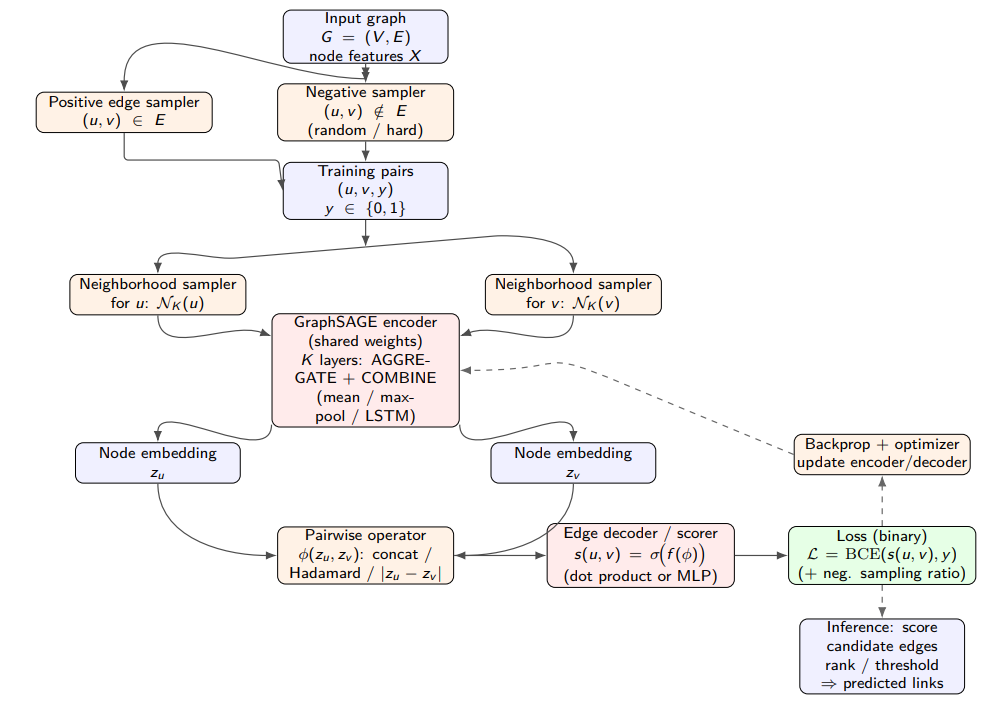

Using device: cpu


,split,positive_edges,negative_edges
0,train,25041,25041
1,val,3129,3129
2,test,3129,3129


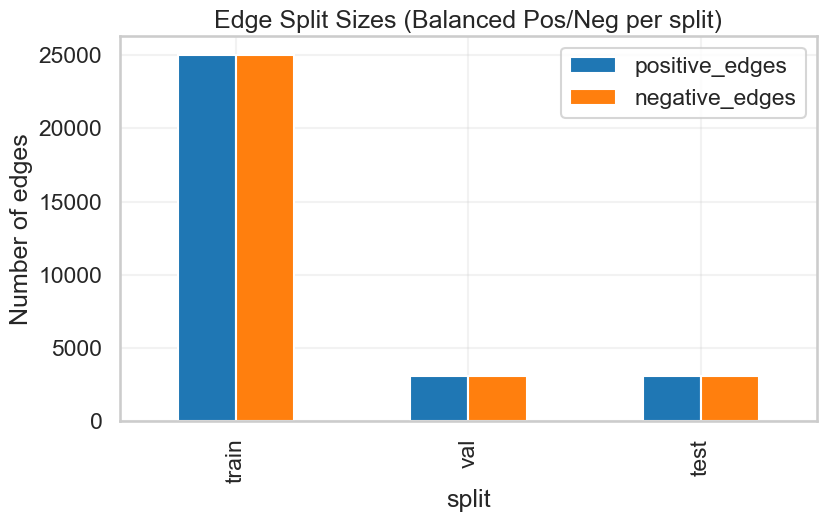

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

nodes_sorted = sorted(G.nodes())
mapping = {node: idx for idx, node in enumerate(nodes_sorted)}
G_lp = nx.relabel_nodes(G, mapping, copy=True)


def split_edges_for_link_prediction(graph, val_ratio=0.10, test_ratio=0.10, seed=42):
    edges = np.array([(u, v) if u < v else (v, u) for u, v in graph.edges()], dtype=np.int64)
    edges = np.unique(edges, axis=0)

    rng = np.random.default_rng(seed)
    rng.shuffle(edges)

    n_edges = len(edges)
    n_test = int(n_edges * test_ratio)
    n_val = int(n_edges * val_ratio)

    test_pos = edges[:n_test]
    val_pos = edges[n_test:n_test + n_val]
    train_pos = edges[n_test + n_val:]

    train_graph = nx.Graph()
    train_graph.add_nodes_from(range(graph.number_of_nodes()))
    train_graph.add_edges_from(train_pos.tolist())

    return train_graph, train_pos, val_pos, test_pos


def sample_negative_edges(num_nodes, forbidden_edges, num_samples, rng):
    sampled = set()
    while len(sampled) < num_samples:
        u = int(rng.integers(0, num_nodes))
        v = int(rng.integers(0, num_nodes))
        if u == v:
            continue
        a, b = (u, v) if u < v else (v, u)
        if (a, b) in forbidden_edges or (a, b) in sampled:
            continue
        sampled.add((a, b))
    return np.array(list(sampled), dtype=np.int64)


train_graph, train_pos, val_pos, test_pos = split_edges_for_link_prediction(
    G_lp, val_ratio=0.10, test_ratio=0.10, seed=SEED
)

all_positive_edges = set((u, v) if u < v else (v, u) for u, v in G_lp.edges())
rng = np.random.default_rng(SEED)
train_neg = sample_negative_edges(G_lp.number_of_nodes(), all_positive_edges, len(train_pos), rng)
val_neg = sample_negative_edges(G_lp.number_of_nodes(), all_positive_edges, len(val_pos), rng)
test_neg = sample_negative_edges(G_lp.number_of_nodes(), all_positive_edges, len(test_pos), rng)

split_df = pd.DataFrame(
    {
        'split': ['train', 'val', 'test'],
        'positive_edges': [len(train_pos), len(val_pos), len(test_pos)],
        'negative_edges': [len(train_neg), len(val_neg), len(test_neg)],
    }
)

display(split_df)

ax = split_df.set_index('split')[['positive_edges', 'negative_edges']].plot(
    kind='bar',
    figsize=(9, 5),
    color=['#1f77b4', '#ff7f0e'],
)
ax.set_title('Edge Split Sizes (Balanced Pos/Neg per split)')
ax.set_ylabel('Number of edges')
ax.grid(alpha=0.25)
plt.show()

Feature matrix shape: torch.Size([1912, 5])
Sparse adjacency nnz: 50,082


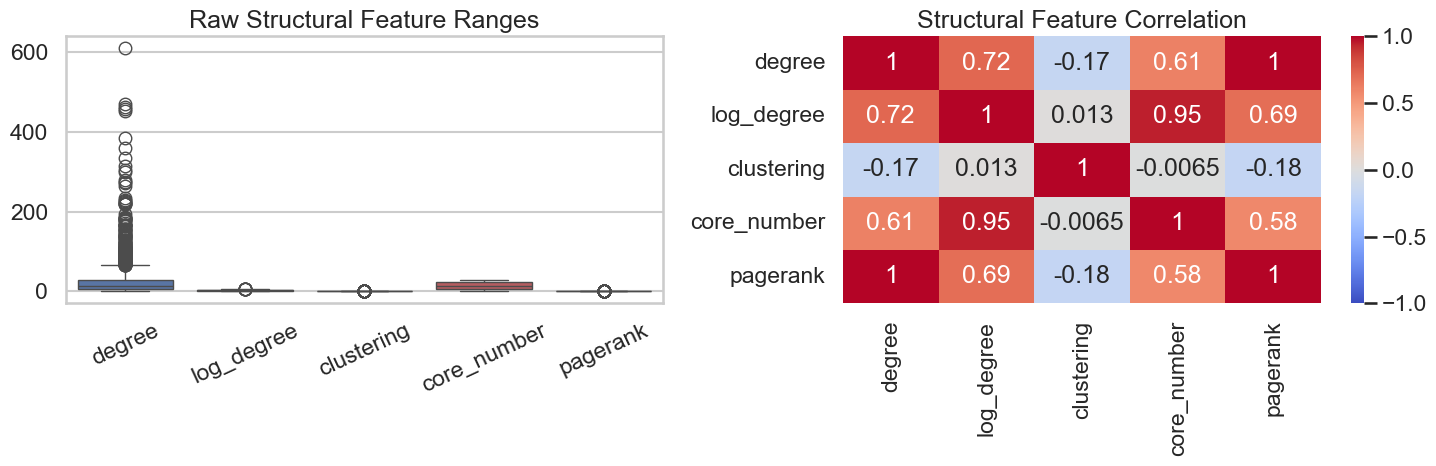

In [15]:
def build_structural_features(graph):
    n = graph.number_of_nodes()
    degree = np.array([graph.degree(i) for i in range(n)], dtype=np.float32)
    log_degree = np.log1p(degree)
    clustering = np.array([nx.clustering(graph, i) for i in range(n)], dtype=np.float32)
    core = nx.core_number(graph)
    core_number = np.array([core[i] for i in range(n)], dtype=np.float32)
    pagerank_map = nx.pagerank(graph, alpha=0.85, max_iter=200)
    pagerank = np.array([pagerank_map[i] for i in range(n)], dtype=np.float32)

    raw = pd.DataFrame(
        {
            'degree': degree,
            'log_degree': log_degree,
            'clustering': clustering,
            'core_number': core_number,
            'pagerank': pagerank,
        }
    )

    scaler = StandardScaler()
    scaled = scaler.fit_transform(raw.values).astype(np.float32)
    return raw, scaled


def build_row_normalized_adjacency(graph, device):
    n = graph.number_of_nodes()
    undirected_edges = np.array(list(graph.edges()), dtype=np.int64)

    if len(undirected_edges) == 0:
        idx = torch.empty((2, 0), dtype=torch.long, device=device)
        val = torch.empty((0,), dtype=torch.float32, device=device)
        return torch.sparse_coo_tensor(idx, val, (n, n), device=device).coalesce()

    row = np.concatenate([undirected_edges[:, 0], undirected_edges[:, 1]])
    col = np.concatenate([undirected_edges[:, 1], undirected_edges[:, 0]])
    data = np.ones(len(row), dtype=np.float32)

    out_degree = np.bincount(row, minlength=n).astype(np.float32)
    norm = data / np.clip(out_degree[row], 1.0, None)

    idx = torch.tensor(np.vstack([row, col]), dtype=torch.long, device=device)
    val = torch.tensor(norm, dtype=torch.float32, device=device)
    return torch.sparse_coo_tensor(idx, val, (n, n), device=device).coalesce()


feature_raw_df, x_np = build_structural_features(train_graph)
x = torch.tensor(x_np, dtype=torch.float32, device=device)
adj_train = build_row_normalized_adjacency(train_graph, device)

print(f'Feature matrix shape: {x.shape}')
print(f'Sparse adjacency nnz: {adj_train._nnz():,}')

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(data=feature_raw_df, ax=axes[0])
axes[0].set_title('Raw Structural Feature Ranges')
axes[0].tick_params(axis='x', rotation=25)

sns.heatmap(feature_raw_df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[1])
axes[1].set_title('Structural Feature Correlation')

plt.tight_layout()
plt.show()

In [16]:
class GraphSAGELayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.lin_self = nn.Linear(in_dim, out_dim)
        self.lin_neigh = nn.Linear(in_dim, out_dim)

    def forward(self, node_features, adj):
        neigh = torch.sparse.mm(adj, node_features)
        return F.relu(self.lin_self(node_features) + self.lin_neigh(neigh))


class GraphSAGEEncoder(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, dropout=0.2):
        super().__init__()
        self.layer1 = GraphSAGELayer(in_dim, hidden_dim)
        self.layer2 = GraphSAGELayer(hidden_dim, out_dim)
        self.dropout = dropout

    def forward(self, x, adj):
        h = self.layer1(x, adj)
        h = F.dropout(h, p=self.dropout, training=self.training)
        h = self.layer2(h, adj)
        return h


class LinkPredictor(nn.Module):
    def __init__(self, embed_dim, hidden_dim=64):
        super().__init__()
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, src_embed, dst_embed):
        pair = src_embed * dst_embed
        h = F.relu(self.fc1(pair))
        return self.fc2(h).squeeze(-1)


def edges_to_tensor(edge_array, device):
    return torch.tensor(edge_array, dtype=torch.long, device=device)


train_pos_t = edges_to_tensor(train_pos, device)
train_neg_t = edges_to_tensor(train_neg, device)
val_pos_t = edges_to_tensor(val_pos, device)
val_neg_t = edges_to_tensor(val_neg, device)
test_pos_t = edges_to_tensor(test_pos, device)
test_neg_t = edges_to_tensor(test_neg, device)

encoder = GraphSAGEEncoder(in_dim=x.shape[1], hidden_dim=64, out_dim=64, dropout=0.2).to(device)
predictor = LinkPredictor(embed_dim=64, hidden_dim=64).to(device)

print(encoder)
print(predictor)

GraphSAGEEncoder(
  (layer1): GraphSAGELayer(
    (lin_self): Linear(in_features=5, out_features=64, bias=True)
    (lin_neigh): Linear(in_features=5, out_features=64, bias=True)
  )
  (layer2): GraphSAGELayer(
    (lin_self): Linear(in_features=64, out_features=64, bias=True)
    (lin_neigh): Linear(in_features=64, out_features=64, bias=True)
  )
)
LinkPredictor(
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


Epoch 001 | loss=0.3839 | val_auc=0.9189 | val_ap=0.9124 | val_acc=0.7402
Epoch 025 | loss=0.3101 | val_auc=0.9227 | val_ap=0.9197 | val_acc=0.8514
Test ROC-AUC: 0.9237
Test AP:      0.9247
Test ACC@0.5: 0.8520


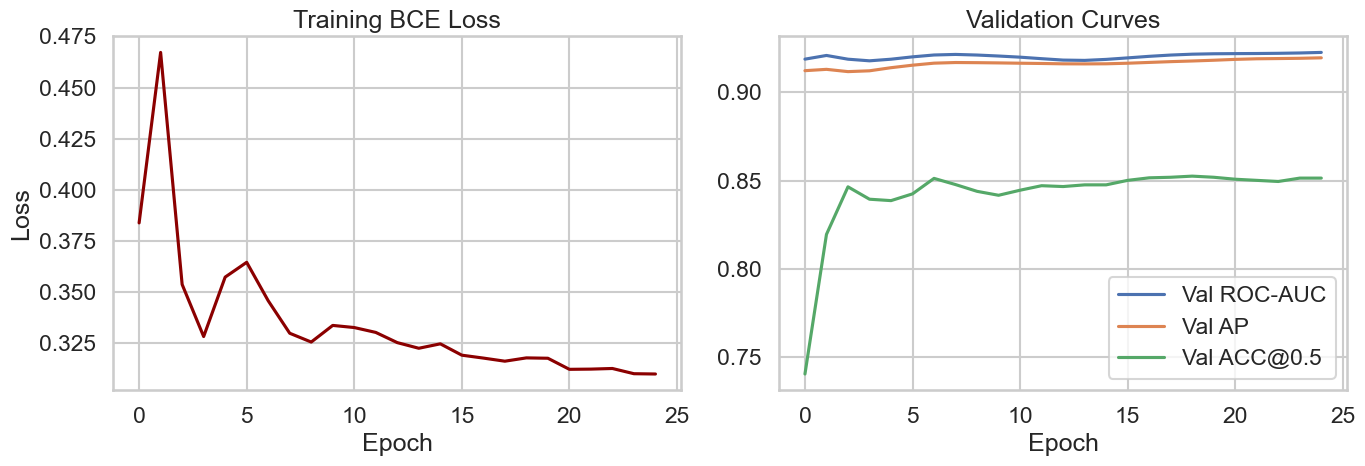

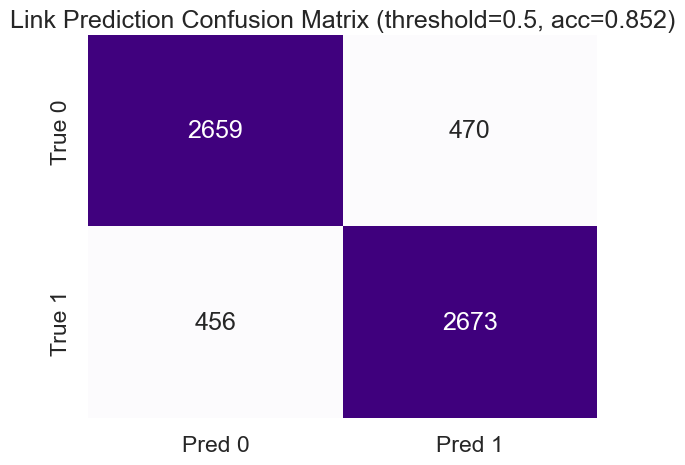

In [23]:
def edge_logits(node_embeddings, edges_tensor, predictor_model):
    src = node_embeddings[edges_tensor[:, 0]]
    dst = node_embeddings[edges_tensor[:, 1]]
    return predictor_model(src, dst)


@torch.no_grad()
def evaluate_split(encoder_model, predictor_model, node_features, adj, pos_edges, neg_edges):
    encoder_model.eval()
    predictor_model.eval()

    z = encoder_model(node_features, adj)
    pos_logits = edge_logits(z, pos_edges, predictor_model)
    neg_logits = edge_logits(z, neg_edges, predictor_model)

    probs = torch.sigmoid(torch.cat([pos_logits, neg_logits], dim=0)).cpu().numpy()
    labels = np.concatenate([
        np.ones(pos_logits.shape[0], dtype=np.int64),
        np.zeros(neg_logits.shape[0], dtype=np.int64),
    ])
    pred = (probs >= 0.5).astype(int)

    auc = roc_auc_score(labels, probs)
    ap = average_precision_score(labels, probs)
    acc = accuracy_score(labels, pred)
    return auc, ap, acc, probs, labels


optimizer = torch.optim.Adam(
    list(encoder.parameters()) + list(predictor.parameters()),
    lr=1e-2,
    weight_decay=1e-4,
)

num_epochs = 25
patience = 40
best_val_ap = -np.inf
best_state = None
no_improve = 0

history = {'loss': [], 'val_auc': [], 'val_ap': [], 'val_acc': []}

for epoch in range(1, num_epochs + 1):
    encoder.train()
    predictor.train()
    optimizer.zero_grad()

    z = encoder(x, adj_train)
    pos_logits = edge_logits(z, train_pos_t, predictor)
    neg_logits = edge_logits(z, train_neg_t, predictor)

    logits = torch.cat([pos_logits, neg_logits], dim=0)
    labels = torch.cat([
        torch.ones_like(pos_logits),
        torch.zeros_like(neg_logits),
    ], dim=0)

    loss = F.binary_cross_entropy_with_logits(logits, labels)
    loss.backward()
    optimizer.step()

    val_auc, val_ap, val_acc, _, _ = evaluate_split(encoder, predictor, x, adj_train, val_pos_t, val_neg_t)

    history['loss'].append(float(loss.item()))
    history['val_auc'].append(float(val_auc))
    history['val_ap'].append(float(val_ap))
    history['val_acc'].append(float(val_acc))

    if val_ap > best_val_ap:
        best_val_ap = val_ap
        no_improve = 0
        best_state = {
            'encoder': copy.deepcopy(encoder.state_dict()),
            'predictor': copy.deepcopy(predictor.state_dict()),
        }
    else:
        no_improve += 1

    if epoch % 25 == 0 or epoch == 1:
        print(
            f'Epoch {epoch:03d} | loss={loss.item():.4f} | '
            f'val_auc={val_auc:.4f} | val_ap={val_ap:.4f} | val_acc={val_acc:.4f}'
        )

    if no_improve >= patience:
        print(f'Early stopping at epoch {epoch}. Best val AP={best_val_ap:.4f}')
        break

if best_state is not None:
    encoder.load_state_dict(best_state['encoder'])
    predictor.load_state_dict(best_state['predictor'])


test_auc, test_ap, test_acc, test_probs, test_labels = evaluate_split(
    encoder,
    predictor,
    x,
    adj_train,
    test_pos_t,
    test_neg_t,
)
print(f'Test ROC-AUC: {test_auc:.4f}')
print(f'Test AP:      {test_ap:.4f}')
print(f'Test ACC@0.5: {test_acc:.4f}')

pred_test = (test_probs >= 0.5).astype(int)
cm_link = confusion_matrix(test_labels, pred_test, labels=[0, 1])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(history['loss'], color='darkred')
axes[0].set_title('Training BCE Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')

axes[1].plot(history['val_auc'], label='Val ROC-AUC')
axes[1].plot(history['val_ap'], label='Val AP')
axes[1].plot(history['val_acc'], label='Val ACC@0.5')
axes[1].set_title('Validation Curves')
axes[1].set_xlabel('Epoch')
axes[1].legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_link,
    annot=True,
    fmt='d',
    cmap='Purples',
    cbar=False,
    xticklabels=['Pred 0', 'Pred 1'],
    yticklabels=['True 0', 'True 1'],
)
plt.title(f'Link Prediction Confusion Matrix (threshold=0.5, acc={test_acc:.3f})')
plt.tight_layout()
plt.show()


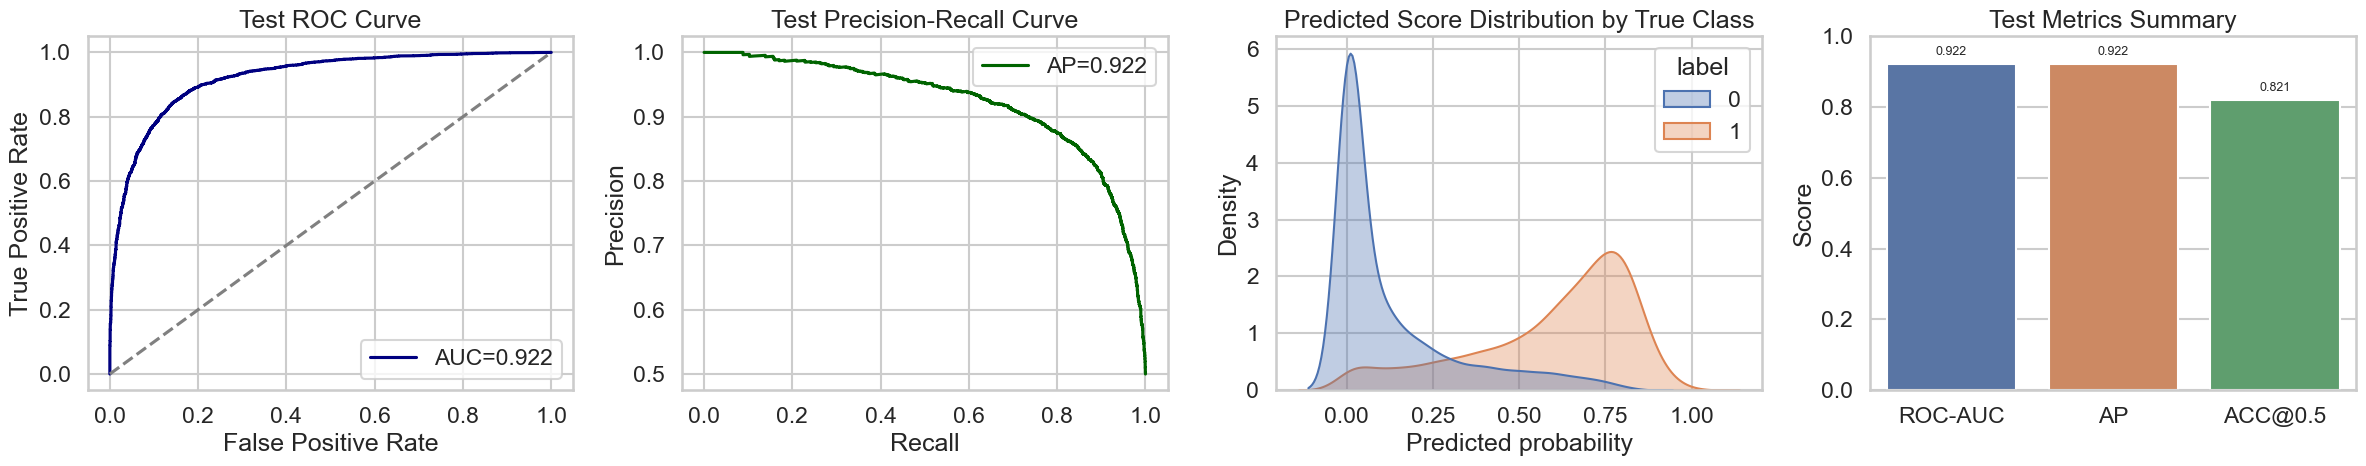

Node 127 recommendations: [(1476, 0.9999822378158569), (1660, 0.9997125267982483), (1593, 0.994549572467804), (103, 0.9938976168632507), (733, 0.9649591445922852)]
Node 1476 recommendations: [(127, 0.9999822378158569), (467, 0.9994668364524841), (1660, 0.9974654912948608), (67, 0.9944970011711121), (1320, 0.9924945831298828)]
Node 1297 recommendations: [(103, 0.9711923599243164), (428, 0.9636474847793579), (471, 0.9593796133995056), (805, 0.9285966753959656), (1836, 0.926275372505188)]
Node 467 recommendations: [(1476, 0.9994668364524841), (290, 0.9991575479507446), (1320, 0.9903500080108643), (836, 0.9212584495544434), (746, 0.9205927848815918)]
Node 290 recommendations: [(467, 0.9991575479507446), (1758, 0.9813538789749146), (287, 0.9527629613876343), (733, 0.9178678393363953), (1484, 0.9141712188720703)]


In [22]:
fpr, tpr, _ = roc_curve(test_labels, test_probs)
prec, rec, _ = precision_recall_curve(test_labels, test_probs)

fig, axes = plt.subplots(1, 4, figsize=(24, 5))

axes[0].plot(fpr, tpr, color='navy', label=f'AUC={test_auc:.3f}')
axes[0].plot([0, 1], [0, 1], '--', color='gray')
axes[0].set_title('Test ROC Curve')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend()

axes[1].plot(rec, prec, color='darkgreen', label=f'AP={test_ap:.3f}')
axes[1].set_title('Test Precision-Recall Curve')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].legend()

scores_df = pd.DataFrame({'score': test_probs, 'label': test_labels})
sns.kdeplot(data=scores_df, x='score', hue='label', fill=True, common_norm=False, alpha=0.35, ax=axes[2])
axes[2].set_title('Predicted Score Distribution by True Class')
axes[2].set_xlabel('Predicted probability')

metrics_df = pd.DataFrame(
    {
        'metric': ['ROC-AUC', 'AP', 'ACC@0.5'],
        'value': [test_auc, test_ap, test_acc],
    }
)
bar = sns.barplot(data=metrics_df, x='metric', y='value', ax=axes[3], hue='metric', legend=False)
axes[3].set_title('Test Metrics Summary')
axes[3].set_xlabel('')
axes[3].set_ylabel('Score')
axes[3].set_ylim(0, 1)
for p in bar.patches:
    h = p.get_height()
    if np.isfinite(h):
        axes[3].annotate(
            f'{h:.3f}',
            (p.get_x() + p.get_width() / 2.0, h),
            ha='center',
            va='bottom',
            xytext=(0, 4),
            textcoords='offset points',
            fontsize=9,
        )

plt.tight_layout()
plt.show()

@torch.no_grad()
def recommend_links_for_node(node_id, graph, encoder_model, predictor_model, node_features, adj, top_k=5):
    encoder_model.eval()
    predictor_model.eval()

    z = encoder_model(node_features, adj)
    neighbors = set(graph.neighbors(node_id))
    neighbors.add(node_id)

    candidates = [v for v in range(graph.number_of_nodes()) if v not in neighbors]
    src = torch.full((len(candidates),), int(node_id), dtype=torch.long, device=device)
    dst = torch.tensor(candidates, dtype=torch.long, device=device)

    probs = torch.sigmoid(predictor_model(z[src], z[dst])).cpu().numpy()
    top_idx = np.argsort(probs)[::-1][:top_k]
    return [(int(candidates[i]), float(probs[i])) for i in top_idx]

anchor_nodes = [n for n, _ in sorted(train_graph.degree(), key=lambda x: x[1], reverse=True)[:5]]
for node in anchor_nodes:
    print(f'Node {node} recommendations: {recommend_links_for_node(node, train_graph, encoder, predictor, x, adj_train, top_k=5)}')


###  Observations

**Quick stabilization (early stopping-friendly):**  
Training BCE loss drops to ~0.31 within ~10–15 epochs and then flattens. Validation ROC-AUC/AP are already ~0.91–0.92 early and remain essentially flat, so additional epochs provide minimal gains.

**Strong ranking performance:**  
Test ROC-AUC ≈ 0.922 and test AP ≈ 0.922 indicate the model ranks true links above non-links effectively (useful for top-K link recommendation).

**Threshold performance is weaker than ranking:**  
Test ACC@0.5 ≈ 0.821 (metrics summary) suggests that although ranking is strong, a fixed 0.5 cutoff leaves noticeable overlap and ambiguity in predicted probabilities.

**Balanced error profile at threshold = 0.5 (confusion matrix):**  
TN = 2659, FP = 470, FN = 456, TP = 2673 →  
precision ≈ 0.851, recall ≈ 0.854, specificity ≈ 0.850, F1 ≈ 0.852.  
FP and FN are similar, so the 0.5 threshold is roughly balanced rather than skewed toward precision or recall.

**Score distributions explain the gap:**  
Negatives cluster near 0, positives concentrate around ~0.6–0.8, but there is a clear overlap region. Most errors come from these mid-score edges (prime candidates for hard-negative mining or feature/neighbor sampling improvements).

**PR curve takeaway:**  
Precision stays high for moderate recall but drops as recall approaches 1. If very high recall is required, more false positives should be expected unless thresholding.